In [66]:
import pandas as pd
from collections import Counter
import ast
import re
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import math

In [2]:
credits=pd.read_csv('data/the-movies-dataset/credits.csv')
movies=pd.read_csv('data/the-movies-dataset/movies_metadata.csv')

C:\Users\B-17\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Merge Credits & Movies

In [3]:
credits.info()
credits['id']=credits['id'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [4]:
me=pd.merge(credits, movies, left_on='id', right_on='id', how="right").drop_duplicates()
me.shape

(45466, 26)

In [5]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'cast', 'crew']
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

me = text_to_dict(me)

# 2. Make new Column ( genres, spoken_language, cast)

In [6]:
me['num_genres'] = me['genres'].apply(lambda x: len(x) if x != {} else 0)
me['num_genres']
me['all_genres'] = me['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')


list_of_genres = list(me['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    me['genre_' + g] = me['all_genres'].apply(lambda x: 1 if g in x else 0)



me['all_casts'] = me['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
list_of_casts = list(me['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_casts = [m[0] for m in Counter([i for j in list_of_casts for i in j]).most_common(1000)]
for c in top_casts:
    me['cast_' + c] = me['all_casts'].apply(lambda x: 1 if c in x else 0)

#all_spoken_languages
me['all_spoken_languages'] = me['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
list_of_casts = list(me['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x] if x != {} else []).values)
top_casts = [m[0] for m in Counter([i for j in list_of_casts for i in j]).most_common(15)]
for c in top_casts:
    me['spoken_language_' + c] = me['all_casts'].apply(lambda x: 1 if c in x else 0)


# 3. NaN값 제거

In [7]:
me=me[(me['cast']!="[]") & (me['crew']!="[]")]

drop_columns=['homepage','poster_path','tagline','video']
me.drop(drop_columns, axis=1, inplace=True)

me=me[me['imdb_id'].notnull()]
me['overview'].fillna("", inplace=True)
me=me[me['popularity'].notnull()]
me['release_date']=me['release_date'].fillna("")

drop_rows=['original_language','revenue','spoken_languages','title','vote_average','vote_count']
for d in drop_rows:
    me=me[me[d].notnull()]
me=me[me['status']=='Released']
me=me[me['runtime'].notnull()]
me['belongs_to_collection'].fillna("{}", inplace=True)
me['adult']=me['adult'].apply(lambda x: 1 if True ==x else 0)

# 4. Date 나누기

In [8]:
# release_date - Release date of a movie in mm/dd/yy format
date=me['release_date'].str.split('-',expand=True)
me['release_month']=date.iloc[:,1]
me['release_day']=date.iloc[:,2]
me['release_year']=date.iloc[:,0]


# 5. make new columns to Commany Values

In [9]:
#production_companies
me['all_production_companies'] = me['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
list_of_casts = list(me['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_casts)
top_casts = [m[0] for m in Counter([i for j in list_of_casts for i in j]).most_common(50)]
for c in top_casts:
    me['production_company_' + c] = me['all_production_companies'].apply(lambda x: 1 if c in x else 0)


[['Pixar Animation Studios'], ['TriStar Pictures', 'Teitler Film', 'Interscope Communications'], ['Warner Bros.', 'Lancaster Gate'], ['Twentieth Century Fox Film Corporation'], ['Sandollar Productions', 'Touchstone Pictures'], ['Regency Enterprises', 'Forward Pass', 'Warner Bros.'], ['Paramount Pictures', 'Scott Rudin Productions', 'Mirage Enterprises', 'Sandollar Productions', 'Constellation Entertainment', 'Worldwide', 'Mont Blanc Entertainment GmbH'], ['Walt Disney Pictures'], ['Universal Pictures', 'Imperial Entertainment', 'Signature Entertainment'], ['United Artists', 'Eon Productions'], ['Columbia Pictures', 'Castle Rock Entertainment'], ['Columbia Pictures', 'Castle Rock Entertainment', 'Enigma Pictures'], ['Universal Pictures', 'Amblin Entertainment', 'Amblimation'], ['Hollywood Pictures', 'Cinergi Pictures Entertainment'], ['Le Studio Canal+', 'Laurence Mark Productions', 'Metro-Goldwyn-Mayer (MGM)', 'Carolco Pictures'], ['Universal Pictures', 'Légende Entreprises', 'Syalis D

# 6. 컬럼확인

In [10]:
i = 1
for column in list(me.columns):
    print("\""+column+"\", ", end='')
    i = i + 1

"cast", "crew", "id", "adult", "belongs_to_collection", "budget", "genres", "imdb_id", "original_language", "original_title", "overview", "popularity", "production_companies", "production_countries", "release_date", "revenue", "runtime", "spoken_languages", "status", "title", "vote_average", "vote_count", "num_genres", "all_genres", "genre_Drama", "genre_Comedy", "genre_Thriller", "genre_Romance", "genre_Action", "genre_Horror", "genre_Crime", "genre_Documentary", "genre_Adventure", "genre_Science Fiction", "genre_Family", "genre_Mystery", "genre_Fantasy", "genre_Animation", "genre_Foreign", "all_casts", "cast_Bess Flowers", "cast_Christopher Lee", "cast_John Wayne", "cast_Samuel L. Jackson", "cast_Gérard Depardieu", "cast_Michael Caine", "cast_John Carradine", "cast_Jackie Chan", "cast_Donald Sutherland", "cast_Frank Welker", "cast_Robert De Niro", "cast_Danny Trejo", "cast_Steve Buscemi", "cast_Irving Bacon", "cast_John Goodman", "cast_Christopher Walken", "cast_Danny Glover", "cast_

# 7. Budget 채우기

In [11]:
me['budget']=me['budget'].astype(int)    
#me.corr()

In [12]:
def predict_bg(data):
    dataBudget0=data[data['budget']==0]
    dataBudgetNot0=data[data['budget']!=0]
    
    # 변수들 -> 예산 예측
    xdata=['revenue','vote_count','popularity','num_genres','genre_Family','cast_Samuel L. Jackson','runtime','genre_Action','genre_Adventure','genre_Fantasy','genre_Science Fiction']
    dataBudgetNot0['budget']=dataBudgetNot0['budget'].astype('str')
    
    # 랜덤포레스트 분류기
    rfm_budget=RandomForestClassifier()
    rfm_budget.fit(dataBudgetNot0[xdata],dataBudgetNot0['budget'])
    budget0Values=rfm_budget.predict(dataBudget0[xdata])
    
    preBudget0=dataBudget0
    preBudgetNot0=dataBudgetNot0
    preBudget0['budget']=budget0Values
    data=preBudgetNot0.append(preBudget0)
    return data

me=predict_bg(me)
me

C:\Users\B-17\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\B-17\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,cast,crew,id,adult,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,...,production_company_Working Title Films,production_company_Hollywood Pictures,production_company_Channel Four Films,production_company_Shaw Brothers,production_company_Film i Väst,production_company_Nordisk Film,production_company_Film4,production_company_Lions Gate Films,production_company_TLA Releasing,production_company_Castle Rock Entertainment
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",tt0114709,en,Toy Story,...,0,0,0,0,0,0,0,0,0,0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,0,{},65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",tt0113497,en,Jumanji,...,0,0,0,0,0,0,0,0,0,0
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,0,{},16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0114885,en,Waiting to Exhale,...,0,0,0,0,0,0,0,0,0,0
5,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",949,0,{},60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",tt0113277,en,Heat,...,0,0,0,0,0,0,0,0,0,0
6,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",11860,0,{},58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",tt0114319,en,Sabrina,...,0,0,0,0,0,0,0,0,0,0
8,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",9091,0,{},35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0114576,en,Sudden Death,...,0,0,0,0,0,0,0,0,0,0
9,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710,0,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",tt0113189,en,GoldenEye,...,0,0,0,0,0,0,0,0,0,0
10,"[{'cast_id': 1, 'character': 'Andrew Shepherd'...","[{'credit_id': '52fe44dac3a36847f80adfa3', 'de...",9087,0,{},62000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0112346,en,The American President,...,0,0,0,0,0,0,0,0,0,1
13,"[{'cast_id': 1, 'character': 'Richard Nixon', ...","[{'credit_id': '52fe43c59251416c7501d6f3', 'de...",10858,0,{},44000000,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",tt0113987,en,Nixon,...,0,1,0,0,0,0,0,0,0,0
14,"[{'cast_id': 1, 'character': 'Morgan Adams', '...","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...",1408,0,{},98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0112760,en,Cutthroat Island,...,0,0,0,0,0,0,0,0,0,0


In [13]:
me['budget'].value_counts()

1000000      3101
2000000      2422
10000000     1695
500000       1666
5000000      1405
3000000      1400
1500000      1055
4000000       949
100000        694
1200000       690
2500000       651
6000000       644
15000000      624
12000000      604
200000        583
20000000      555
3500000       491
7000000       488
8000000       462
250000        460
1             440
10000         436
300000        421
2             386
25000000      371
400000        324
30000000      320
25000         312
150000        296
350000        294
             ... 
9804690         1
2627000         1
126000000       1
7900000         1
1880006         1
117000000       1
51500000        1
9780000         1
24500           1
14320000        1
970000          1
1271000         1
3352254         1
34200000        1
590235          1
5037000         1
6788000         1
1350000         1
60              1
25496629        1
11700000        1
163000000       1
99000000        1
2962051         1
3180000   

In [14]:
castList=["cast_Bess Flowers", "cast_Christopher Lee", "cast_John Wayne", "cast_Samuel L. Jackson", "cast_Gérard Depardieu", "cast_Michael Caine", "cast_John Carradine", "cast_Jackie Chan", "cast_Donald Sutherland", "cast_Frank Welker", "cast_Robert De Niro", "cast_Danny Trejo", "cast_Steve Buscemi", "cast_Irving Bacon", "cast_John Goodman", "cast_Christopher Walken", "cast_Danny Glover", "cast_Dennis Hopper", "cast_Susan Sarandon", "cast_John Hurt", "cast_Eric Roberts", "cast_Bruce Willis", "cast_Malcolm McDowell", "cast_Harvey Keitel", "cast_Willem Dafoe", "cast_Anthony Quinn", "cast_Keith David", "cast_Donald Pleasence", "cast_Stellan Skarsgård", "cast_Morgan Freeman", "cast_Whoopi Goldberg", "cast_Max von Sydow", "cast_Robert Duvall", "cast_Charles Lane", "cast_James Franco", "cast_Robin Williams", "cast_Nicolas Cage", "cast_Christopher Plummer", "cast_Alec Baldwin", "cast_Christopher Lloyd", "cast_Liam Neeson", "cast_Keenan Wynn", "cast_Vincent Price", "cast_Harry Dean Stanton", "cast_John Turturro", "cast_John Leguizamo", "cast_Ward Bond", "cast_Gene Hackman", "cast_James Earl Jones", "cast_Brian Cox", "cast_M. Emmet Walsh", "cast_Stanley Tucci", "cast_Ben Kingsley", "cast_Dick Miller", "cast_John George", "cast_Jim Broadbent", "cast_John Cusack", "cast_J.K. Simmons", "cast_Martin Sheen", "cast_Lance Henriksen", "cast_James Caan", "cast_Forest Whitaker", "cast_Peter Stormare", "cast_Burt Reynolds", "cast_James Mason", "cast_Wallace Shawn", "cast_Helen Mirren", "cast_Robert Mitchum", "cast_James Stewart", "cast_Bette Davis", "cast_Ed Harris", "cast_Woody Harrelson", "cast_Ron Perlman", "cast_Richard Jenkins", "cast_William H. Macy", "cast_Rutger Hauer", "cast_Mickey Rooney", "cast_Michael Ironside", "cast_Dan Aykroyd", "cast_Udo Kier", "cast_Henry Fonda", "cast_Boris Karloff", "cast_Tom Hanks", "cast_Paul Giamatti", "cast_Jeff Bridges", "cast_Ned Beatty", "cast_Lionel Barrymore", "cast_Anthony Hopkins", "cast_Christian Slater", "cast_Michael Gambon", "cast_Bruce Dern", "cast_Ray Milland", "cast_Grey Griffin", "cast_Val Kilmer", "cast_James Woods", "cast_Sylvester Stallone", "cast_Robert Downey Jr.", "cast_Nick Nolte", "cast_Vanessa Redgrave", "cast_Ernest Borgnine", "cast_Robert Forster", "cast_Burt Lancaster", "cast_Danny DeVito", "cast_Charles Durning", "cast_Johnny Depp", "cast_Ray Liotta", "cast_Peter Cushing", "cast_Matt Damon", "cast_Mark Strong", "cast_Henry O'Neill", "cast_Rip Torn", "cast_David Strathairn", "cast_Christopher McDonald", "cast_Roddy McDowall", "cast_John Malkovich", "cast_William Hurt", "cast_John Cleese", "cast_Charlton Heston", "cast_Tom Wilkinson", "cast_Antonio Banderas", "cast_Sigourney Weaver", "cast_Laurence Fishburne", "cast_Catherine Deneuve", "cast_Shelley Winters", "cast_Kris Kristofferson", "cast_Jeff Bennett", "cast_Orson Welles", "cast_Kirk Douglas", "cast_Julianne Moore", "cast_Meryl Streep", "cast_Alfred Molina", "cast_Alan Arkin", "cast_Isabelle Huppert", "cast_Dolph Lundgren", "cast_Bill Murray", "cast_Ving Rhames", "cast_Stephen Tobolowsky", "cast_Marcello Mastroianni", "cast_Cary Grant", "cast_Jim Cummings", "cast_Tom Arnold", "cast_Ben Stiller", "cast_Michael Madsen", "cast_Dustin Hoffman", "cast_Rod Steiger", "cast_Paul Fix", "cast_Reginald Owen", "cast_Frank Faylen", "cast_Buster Keaton", "cast_George Sanders", "cast_Sam Neill", "cast_Clint Howard", "cast_Keanu Reeves", "cast_James Remar", "cast_Kathy Bates", "cast_Joss Ackland", "cast_Paul Newman", "cast_Billy Zane", "cast_Raymond Burr", "cast_Humphrey Bogart", "cast_Tom Sizemore", "cast_Kevin Bacon", "cast_Jeff Goldblum", "cast_John C. Reilly", "cast_Dean Stockwell", "cast_Clint Eastwood", "cast_John Heard", "cast_Paul Guilfoyle", "cast_Patrick Stewart", "cast_Dennis Quaid", "cast_Bruce Davison", "cast_Brad Dourif", "cast_Tomás Milián", "cast_Alan Hale", "cast_Barbara Stanwyck", "cast_Charles Bronson", "cast_Edward G. Robinson", "cast_Kevin Pollak", "cast_Sean Bean", "cast_Richard Riehle", "cast_Cloris Leachman", "cast_Brad Pitt", "cast_Geraldine Chaplin", "cast_Michel Piccoli", "cast_George Kennedy", "cast_Oliver Platt", "cast_Gino Corrado", "cast_Joan Crawford", "cast_James Flavin", "cast_J. Carrol Naish", "cast_Mary Steenburgen", "cast_Dermot Mulroney", "cast_Sean Connery", "cast_Liev Schreiber", "cast_Bruce Greenwood", "cast_Lin Shaye", "cast_Ewan McGregor", "cast_Randy Quaid", "cast_Bill Nighy", "cast_Luis Guzmán", "cast_Michael Shannon", "cast_Joseph Crehan", "cast_Charlotte Rampling", "cast_Tim Roth", "cast_Nicole Kidman", "cast_Bill Pullman", "cast_Jim Belushi", "cast_Beth Grant", "cast_Om Puri", "cast_Stephen Root", "cast_Beau Bridges", "cast_Stacy Keach", "cast_Harry Morgan", "cast_David Carradine", "cast_Robert Taylor", "cast_Jon Voight", "cast_Harrison Ford", "cast_Kiefer Sutherland", "cast_Jeffrey Tambor", "cast_Anjelica Huston", "cast_Bill Paxton", "cast_Brian Dennehy", "cast_Ian Holm", "cast_James Hong", "cast_James Garner", "cast_Heather Graham", "cast_Mickey Rourke", "cast_Ian Wolfe", "cast_Sam Rockwell", "cast_Gary Cooper", "cast_Elisha Cook Jr.", "cast_Timothy Spall", "cast_Ray Teal", "cast_Randolph Scott", "cast_Patricia Clarkson", "cast_Walter Matthau", "cast_Jack Lemmon", "cast_Sharon Stone", "cast_John Travolta", "cast_Colleen Camp", "cast_Robert Loggia", "cast_Seymour Cassel", "cast_James Coburn", "cast_Kathleen Freeman", "cast_Sam Shepard", "cast_Ed Lauter", "cast_Franco Nero", "cast_Tom Skerritt", "cast_Russell Hicks", "cast_Akshay Kumar", "cast_Daryl Hannah", "cast_Ciarán Hinds", "cast_Sean Penn", "cast_Helena Bonham Carter", "cast_Jack Nicholson", "cast_Andy García", "cast_Bruce McGill", "cast_John Gielgud", "cast_Vincent D'Onofrio", "cast_Ethan Hawke", "cast_Jack Palance", "cast_Jennifer Tilly", "cast_Cary Elwes", "cast_John Lithgow", "cast_Charlie Sheen", "cast_Tony Curtis", "cast_Robert Patrick", "cast_Bert Moorhouse", "cast_Myrna Loy", "cast_Herbert Lom", "cast_Amitabh Bachchan", "cast_Burgess Meredith", "cast_Pierce Brosnan", "cast_Bob Hoskins", "cast_James Cromwell", "cast_Kevin Spacey", "cast_Gabriel Byrne", "cast_Woody Allen", "cast_Gary Busey", "cast_Brendan Gleeson", "cast_Matthew Lillard", "cast_Rosario Dawson", "cast_Elias Koteas", "cast_Gary Oldman", "cast_Billy Bob Thornton", "cast_Naomi Watts", "cast_Michael McKean", "cast_Shirley MacLaine", "cast_William Holden", "cast_Eli Wallach", "cast_William Demarest", "cast_Donald Crisp", "cast_Lon Chaney Jr.", "cast_Bing Crosby", "cast_Glenn Ford", "cast_Anupam Kher", "cast_Jean-Claude Van Damme", "cast_Richard Dreyfuss", "cast_Marisa Tomei", "cast_Marc Lawrence", "cast_Jonathan Pryce", "cast_Jack Black", "cast_Jack Warden", "cast_Joan Cusack", "cast_Patton Oswalt", "cast_Ernie Hudson", "cast_Kurt Russell", "cast_Sean Astin", "cast_Tom Berenger", "cast_Akim Tamiroff", "cast_Peter Lorre", "cast_John Qualen", "cast_Trevor Howard", "cast_John Mills", "cast_George Chandler", "cast_James Cagney", "cast_Frank McHugh", "cast_David Koechner", "cast_Addison Richards", "cast_John DiMaggio", "cast_Selmer Jackson", "cast_Shah Rukh Khan", "cast_Steve Martin", "cast_Janeane Garofalo", "cast_Ellen Burstyn", "cast_Michael Rapaport", "cast_Philip Baker Hall", "cast_Tim Curry", "cast_Chris Rock", "cast_Tommy Lee Jones", "cast_Drew Barrymore", "cast_Gina Gershon", "cast_Jeff Daniels", "cast_William Shatner", "cast_Elijah Wood", "cast_Jason Robards", "cast_Ed Begley Jr.", "cast_Tilda Swinton", "cast_Robert Ryan", "cast_David Cross", "cast_Clark Gable", "cast_Paul Harvey", "cast_Spencer Tracy", "cast_David Niven", "cast_Byron Foulger", "cast_Walter Brennan", "cast_Karen Black", "cast_Charlie Chaplin", "cast_Robert Wagner", "cast_Lam Suet", "cast_Al Pacino", "cast_Xander Berkeley", "cast_Matthew Modine", "cast_Paul Rudd", "cast_Maggie Smith", "cast_Parker Posey", "cast_Glenn Close", "cast_Bruce Campbell", "cast_Jeremy Irons", "cast_Cuba Gooding Jr.", "cast_Philip Seymour Hoffman", "cast_Allison Janney", "cast_David Warner", "cast_Octavia Spencer", "cast_Sam Harris", "cast_Gregory Peck", "cast_Frank Sinatra", "cast_J. Farrell MacDonald", "cast_Richard Widmark", "cast_Justin Long", "cast_Paresh Rawal", "cast_Paul Sorvino", "cast_Clancy Brown", "cast_Kristin Scott Thomas", "cast_David Thewlis", "cast_Elliott Gould", "cast_Luke Wilson", "cast_Kevin Corrigan", "cast_Aidan Quinn", "cast_Ralph Fiennes", "cast_Kevin Costner", "cast_Colin Firth", "cast_Tim Robbins", "cast_Stephen Rea", "cast_Tara Strong", "cast_Toby Jones", "cast_John Rhys-Davies", "cast_Martin Balsam", "cast_Joseph Cotten", "cast_Ann Doran", "cast_Doris Lloyd", "cast_Dennis O'Keefe", "cast_Vinnie Jones", "cast_Tom Kenny", "cast_Eugene Levy", "cast_Miriam Margolyes", "cast_Frank Langella", "cast_Salma Hayek", "cast_Matt Dillon", "cast_Owen Wilson", "cast_Scarlett Johansson", "cast_Joe Pantoliano", "cast_Jason Flemyng", "cast_Richard Gere", "cast_Catherine Keener", "cast_Scott Glenn", "cast_Rosanna Arquette", "cast_Juliette Binoche", "cast_William Sadler", "cast_Jeff Corey", "cast_Charles Dance", "cast_Kevin Michael Richardson", "cast_Ellen Corby", "cast_Ginger Rogers", "cast_Seth Green", "cast_Harry Andrews", "cast_Denholm Elliott", "cast_Chishu Ryu", "cast_Will Ferrell", "cast_Allen Jenkins", "cast_Jeremy Piven", "cast_Dan Hedaya", "cast_Edward Herrmann", "cast_Denis Leary", "cast_Faye Dunaway", "cast_Julia Roberts", "cast_Peter Coyote", "cast_Peter Boyle", "cast_Robert Redford", "cast_Michael Gough", "cast_Ben Affleck", "cast_Jean Reno", "cast_Rob Paulsen", "cast_Arnold Schwarzenegger", "cast_Michael Lerner", "cast_Michael Paré", "cast_Fred Ward", "cast_Marcia Gay Harden", "cast_Hal Holbrook", "cast_Vernon Dobtcheff", "cast_Jane Fonda", "cast_William Schallert", "cast_Eddie Albert", "cast_Peter O'Toole", "cast_Cameron Mitchell", "cast_C. Aubrey Smith", "cast_Sig Ruman", "cast_Walter Pidgeon", "cast_Vittorio Gassman", "cast_Jack Elam", "cast_Michael Hordern", "cast_Oliver Reed", "cast_Klaus Kinski", "cast_Cate Blanchett", "cast_Morris Ankrum", "cast_Judi Dench", "cast_Anne Bancroft", "cast_Maury Chaykin", "cast_Christina Ricci", "cast_Giancarlo Esposito", "cast_Jennifer Jason Leigh", "cast_Joe Mantegna", "cast_Mike Starr", "cast_George Clooney", "cast_Bob Balaban", "cast_Michael York", "cast_Stephen Lang", "cast_Tim Blake Nelson", "cast_Stan Lee", "cast_Peter Fonda", "cast_Kevin Kline", "cast_Carla Gugino", "cast_Miranda Richardson", "cast_Toni Collette", "cast_Matthew Broderick", "cast_Robert Englund", "cast_Geoffrey Lewis", "cast_Stephen McHattie", "cast_Debbie Reynolds", "cast_Adrien Brody", "cast_Angela Lansbury", "cast_Barbara Hershey", "cast_Pam Grier", "cast_Milton Kibbee", "cast_Fred MacMurray", "cast_Don Beddoe", "cast_Basil Rathbone", "cast_Samuel S. Hinds", "cast_Mary Gordon", "cast_Sammo Hung", "cast_Claudia Cardinale", "cast_Fred Willard", "cast_Joan Blondell", "cast_Sarah Silverman", "cast_Naseeruddin Shah", "cast_Simon Yam", "cast_Wesley Snipes", "cast_Robbie Coltrane", "cast_David Paymer", "cast_Leslie Nielsen", "cast_Winona Ryder", "cast_Molly Shannon", "cast_Cheech Marin", "cast_Carol Kane", "cast_Martin Landau", "cast_Denzel Washington", "cast_Alec Guinness", "cast_Steven Seagal", "cast_Caroline Aaron", "cast_Paul Dooley", "cast_Michael Keaton", "cast_Sam Elliott", "cast_Harry Carey, Jr.", "cast_Alain Delon", "cast_Peter Sellers", "cast_Agnes Moorehead", "cast_Dana Andrews", "cast_Gene Lockhart", "cast_John Ridgely", "cast_John Ireland", "cast_Sidney Poitier", "cast_Eddie Marsan", "cast_Judy Greer", "cast_Lewis Stone", "cast_Mark Ruffalo", "cast_Douglass Dumbrille", "cast_John C. McGinley", "cast_Emma Thompson", "cast_Lili Taylor", "cast_Chris Cooper", "cast_Terrence Howard", "cast_Mel Gibson", "cast_Uma Thurman", "cast_Adam Sandler", "cast_Steve Zahn", "cast_Don Cheadle", "cast_Dylan Baker", "cast_Tom Cruise", "cast_Mark Hamill", "cast_Ray Winstone", "cast_Chevy Chase", "cast_Anthony LaPaglia", "cast_Thomas Kretschmann", "cast_Terence Stamp", "cast_Larry Miller", "cast_Jeanne Moreau", "cast_Lee Phelps", "cast_Douglas Fowley", "cast_Barton MacLane", "cast_Thomas Mitchell", "cast_Edward Brophy", "cast_Van Johnson", "cast_Giovanni Ribisi", "cast_Lee J. Cobb", "cast_Bobby Cannavale", "cast_Andy Lau", "cast_Elizabeth Banks", "cast_Bill Hader", "cast_John Ratzenberger", "cast_Diane Keaton", "cast_Michael Douglas", "cast_Richard Harris", "cast_Richard Schiff", "cast_F. Murray Abraham", "cast_Juliette Lewis", "cast_Jean-Paul Belmondo", "cast_Josh Brolin", "cast_William Forsythe", "cast_Treat Williams", "cast_Diane Lane", "cast_James Le Gros", "cast_Kevin Smith", "cast_Keith Carradine", "cast_Jon Polito", "cast_Teri Garr", "cast_Isabella Rossellini", "cast_Carrie Fisher", "cast_Peter Falk", "cast_Crispin Glover", "cast_Jane Lynch", "cast_Ben Johnson", "cast_Sterling Holloway", "cast_Werner Herzog", "cast_Penélope Cruz", "cast_Leo White", "cast_Jane Darwell", "cast_Charles Middleton", "cast_Alan Mowbray", "cast_Wade Boteler", "cast_Charles Trowbridge", "cast_Karl Malden", "cast_Alan Napier", "cast_Peter Ustinov", "cast_Jim Backus", "cast_Burt Young", "cast_Whit Bissell", "cast_Richard Jaeckel", "cast_Jerry Lewis", "cast_Nestor Paiva", "cast_Alberto Sordi", "cast_Marion Cotillard", "cast_Fred Tatasciore", "cast_Kirsten Dunst", "cast_Ann-Margret", "cast_Alan Cumming", "cast_Alan Rickman", "cast_Jon Gries", "cast_Michael Sheen", "cast_John Saxon", "cast_John Savage", "cast_Melissa Leo", "cast_David Arquette", "cast_Martin Scorsese", "cast_Mark Wahlberg", "cast_Jared Harris", "cast_Virginia Madsen", "cast_Matthew McConaughey", "cast_Michael Lonsdale", "cast_Rob Lowe", "cast_Cameron Diaz", "cast_Dabney Coleman", "cast_Brion James", "cast_Jon Lovitz", "cast_Colm Meaney", "cast_Tracey Walter", "cast_Ray Wise", "cast_Bela Lugosi", "cast_Frank Puglia", "cast_Marcel Dalio", "cast_Olin Howland", "cast_Charles Halton", "cast_Regis Toomey", "cast_Robert Warwick", "cast_Rock Hudson", "cast_John McIntire", "cast_Omar Sharif", "cast_Arthur Kennedy", "cast_Henry Silva", "cast_Jet Li", "cast_John Litel", "cast_Donald Meek", "cast_Clarence Muse", "cast_Dean Martin", "cast_Josh Lucas", "cast_Anthony Wong", "cast_Lee Marvin", "cast_Louise Beavers", "cast_Bud Spencer", "cast_Tadanobu Asano", "cast_Kristen Wiig", "cast_Sophia Loren", "cast_Demi Moore", "cast_Michelle Pfeiffer", "cast_Ian McKellen", "cast_Gwyneth Paltrow", "cast_David Ogden Stiers", "cast_Philippe Noiret", "cast_Steve Coogan", "cast_Pruitt Taylor Vince", "cast_Jude Law", "cast_Jason Isaacs", "cast_George Segal", "cast_Colin Farrell", "cast_Viggo Mortensen", "cast_Armand Assante", "cast_Blythe Danner", "cast_Stephen Fry", "cast_Lambert Wilson", "cast_Tom Dugan", "cast_Richard E. Grant", "cast_Dub Taylor", "cast_Laura Dern", "cast_Dom DeLuise", "cast_Edmond O'Brien", "cast_Lyle Talbot", "cast_Peter Lawford", "cast_Jerome Cowan", "cast_Harry Davenport", "cast_Larry Steers", "cast_Edward Arnold", "cast_Grant Mitchell", "cast_George Irving", "cast_Queen Latifah", "cast_Derek Jacobi", "cast_Virginia Brissac", "cast_Lee Van Cleef", "cast_Royal Dano", "cast_Lochlyn Munro", "cast_James Marsden", "cast_Mathieu Amalric", "cast_Dennis Haysbert", "cast_Greg Kinnear", "cast_Mark Boone Junior", "cast_Pete Postlethwaite", "cast_Eric Stoltz", "cast_Anne Heche", "cast_Eddie Murphy", "cast_Timothy Hutton", "cast_Michael Biehn", "cast_Laura Linney", "cast_Jeffrey Combs", "cast_Marlon Brando", "cast_Donal Logue", "cast_Lauren Bacall", "cast_Jean Rochefort", "cast_Elizabeth Taylor", "cast_André Dussollier", "cast_Lloyd Bridges", "cast_Roy Scheider", "cast_Nastassja Kinski", "cast_Paolo Villaggio", "cast_Frankie Faison", "cast_Mel Blanc", "cast_Til Schweiger", "cast_Rachel Weisz", "cast_Thomas Jane", "cast_Fred Astaire", "cast_Charles Boyer", "cast_Harry Strang", "cast_Monte Blue", "cast_Laurence Olivier", "cast_Edmund Mortimer", "cast_Harry Hayden", "cast_Lane Chandler", "cast_Frank Mayo", "cast_Brian Keith", "cast_Eddie Izzard", "cast_Viola Davis", "cast_Robert Barrat", "cast_Fredric March", "cast_Ryan Reynolds", "cast_Barbara Hale", "cast_Gian Maria Volonté", "cast_Grady Sutton", "cast_Seth Rogen", "cast_Salman Khan", "cast_Jim Carrey", "cast_Will Patton", "cast_Brendan Fraser", "cast_Jean-Louis Trintignant", "cast_Alfre Woodard", "cast_Christian Bale", "cast_Benicio del Toro", "cast_Michael Clarke Duncan", "cast_Rob Schneider", "cast_Pat Hingle", "cast_Frances McDormand", "cast_Mia Farrow", "cast_Ellen Barkin", "cast_Héctor Elizondo", "cast_Tony Shalhoub", "cast_James Whitmore", "cast_Stephen Dorff", "cast_James Russo", "cast_George C. Scott", "cast_Vince Vaughn", "cast_Clive Owen", "cast_Ugo Tognazzi", "cast_Lukas Haas", "cast_Dee Wallace", "cast_Emmett Vogan", "cast_Walter Sande", "cast_Ava Gardner", "cast_Frank Reicher", "cast_Cedric Hardwicke", "cast_Beulah Bondi", "cast_Guy Kibbee", "cast_Leo Gorcey", "cast_James Gleason", "cast_John Hoyt", "cast_Una Merkel", "cast_Eleanor Parker", "cast_Ron Livingston", "cast_Charles McGraw", "cast_Spencer Charters", "cast_Will Wright", "cast_Geoffrey Rush", "cast_Jacqueline Bisset", "cast_Ren Osugi", "cast_Andy Serkis", "cast_Kane Hodder", "cast_Ralph Richardson", "cast_John Miljan", "cast_Richard Kind", "cast_Barry Sullivan", "cast_Jason Bateman", "cast_Anthony Mackie", "cast_Kareena Kapoor", "cast_Priyanka Chopra", "cast_Masako Nozawa", "cast_Philip Ettington", "cast_Margo Martindale", "cast_Kevin Dunn", "cast_L.Q. Jones", "cast_Melanie Griffith", "cast_David Morse", "cast_Clifton Collins Jr", "cast_Mira Sorvino", "cast_Vivica A. Fox", "cast_John Hawkes", "cast_Frank Mills", "cast_James Rebhorn", "cast_John Candy", "cast_Michael Rooker", "cast_Richard Masur", "cast_Katharine Hepburn", "cast_Toshirō Mifune", "cast_Kim Basinger", "cast_Guy Pearce", "cast_Catherine O'Hara", "cast_Louis Gossett, Jr.", "cast_Michael Murphy", "cast_Gary Cole", "cast_Rhys Ifans", "cast_Charles Laughton", "cast_Cecil Kellaway", "cast_Robert Vaughn", "cast_E.E. Clive", "cast_Stuart Holmes", "cast_Claude Rains", "cast_Walter Huston", "cast_Holmes Herbert", "cast_Harold Miller", "cast_Steven Geray", "cast_Herbert Marshall", "cast_Wallace Ford", "cast_Melvyn Douglas", "cast_Harry Cording", "cast_Lucille Ball", "cast_Robert Morley", "cast_Huntz Hall", "cast_Joe Sawyer", "cast_Charlize Theron", "cast_C. Thomas Howell", "cast_Michael Peña", "cast_Ed Asner", "cast_Brian Donlevy", "cast_Dean Jagger", "cast_Jason Statham", "cast_Alan Bates", "cast_Ian McShane", "cast_Johnny Lever", "cast_Bernard Blier", "cast_Ajay Devgn", "cast_Natalie Portman", "cast_Hank Azaria", "cast_Bob Gunton", "cast_James Gandolfini", "cast_Kenneth Branagh", "cast_Hugo Weaving", "cast_Peter Sarsgaard", "cast_Charles S. Dutton", "cast_Matt Frewer", "cast_Jason Alexander", "cast_Vincent Cassel", "cast_Ron Jeremy", "cast_Danny Aiello", "cast_Eric Idle", "cast_Angelina Jolie", "cast_Billy Crystal", "cast_Richard Anderson", "cast_Daniel Craig", "cast_Jean-Claude Brialy", "cast_Peter Gallagher", "cast_Sean Young", "cast_James Fox", "cast_Moroni Olsen", "cast_Ralph Bellamy", "cast_Lou Diamond Phillips", "cast_Mary Kay Place", "cast_Ingrid Bergman", "cast_Mike Mazurki", "cast_Emory Parnell", "cast_Leon Ames", "cast_Nigel Bruce", "cast_Reginald Denny", "cast_William Powell", "cast_Brooks Benedict", "cast_Pierre Watkin", "cast_Henry Stephenson", "cast_Will Arnett", "cast_Kathy Baker", "cast_Robert Young", "cast_Mae Marsh", "cast_Emily Watson", "cast_Lucy Liu", "cast_Danny Huston", "cast_Sid Haig", "cast_Fernando Rey", "cast_Takashi Shimura", "cast_Mary Field", "cast_Maria Bello", "cast_Amy Adams", "cast_Patrick Warburton", "cast_Dakota Fanning", "cast_Yuen Biao", "cast_Michael Nyqvist", "cast_Willard Robertson", "cast_Simon Pegg", "cast_Daniel Brühl", "cast_Jonah Hill", "cast_R. Lee Ermey", "cast_William Fichtner", "cast_Famke Janssen", "cast_Michael J. Fox", "cast_John Diehl", "cast_Scott Wilson", "cast_Cary-Hiroyuki Tagawa", "cast_Olympia Dukakis", "cast_David Keith", "cast_Beverly D'Angelo", "cast_Sandra Bullock", "cast_Tom Lister Jr.", "cast_Kevin McCarthy", "cast_Stockard Channing", "cast_Shirley Henderson", "cast_Jürgen Prochnow", "cast_Rade Serbedzija", "cast_Griffin Dunne", "cast_Tony Todd", "cast_Jamie Lee Curtis", "cast_Reese Witherspoon", "cast_Grace Zabriskie", "cast_Bill Moseley", "cast_Patrick Bauchau", "cast_Strother Martin", "cast_Adam Scott", "cast_Leslie Phillips", "cast_Sissy Spacek", "cast_Eric Tsang", "cast_Murray Alper", "cast_Chill Wills", "cast_Cyril Ring", "cast_Billy Bevan", "cast_Joel McCrea", "cast_George Davis", "cast_George Tobias", "cast_Pat Flaherty", "cast_Edgar Buchanan", "cast_Rhys Williams", "cast_Bernard Lee", "cast_Janet Leigh", "cast_Cyril Cusack", "cast_Lionel Stander", "cast_Susumu Terajima", "cast_Giuliano Gemma", "cast_Frank Ferguson", "cast_Richard Pryor", "cast_John Michael Higgins", "cast_Missi Pyle", "cast_Jonathan Hale", "cast_Alan Tudyk", "cast_Adolfo Celi", "cast_Amy Poehler", "cast_Mike Epps", "cast_Hugh Jackman", "cast_Rachael Leigh Cook", "cast_Tchéky Karyo", "cast_Kate Winslet", "cast_Steve Guttenberg", "cast_Billy Connolly", "cast_Joseph Gordon-Levitt", "cast_John Carroll Lynch", "cast_James Cosmo", "cast_Jodie Foster", "cast_Kenneth Welsh", "cast_Dianne Wiest", "cast_Jessica Lange", "cast_Chloë Sevigny", "cast_Jason Lee", "cast_Maximilian Schell", "cast_Daniel Auteuil", "cast_Russell Crowe", "cast_Woody Strode", "cast_James Spader", "cast_Gary Lewis", "cast_Corbin Bernsen", "cast_George Buck Flower", "cast_Callum Keith Rennie", "cast_Lena Headey", "cast_Tom Selleck", "cast_Billy Gilbert", "cast_Warren Oates", "cast_Jeffrey Wright", "cast_Barry Corbin", "cast_Jamie Foxx", "cast_Cesar Romero", "cast_Halliwell Hobbes", "cast_Frank Wilcox", "cast_Mary Astor", "cast_Jack Mower", "cast_Frank Morgan", "cast_Leyland Hodgson", "cast_Louis Calhern", "cast_Eugene Pallette", "cast_Edward Gargan", "cast_William B. Davidson", "cast_John Doucette", "cast_Natasha Lyonne", "cast_Olivier Gourmet"]

In [15]:
genreList=["genre_Drama", "genre_Comedy", "genre_Thriller", "genre_Romance", "genre_Action", "genre_Horror", "genre_Crime", "genre_Documentary", "genre_Adventure", "genre_Science Fiction", "genre_Family", "genre_Mystery", "genre_Fantasy", "genre_Animation", "genre_Foreign"]
str=""
for ge in genreList:
    str=str+"(me[\""+ge+"\"]!=0) |"
str   

'(me["genre_Drama"]!=0) |(me["genre_Comedy"]!=0) |(me["genre_Thriller"]!=0) |(me["genre_Romance"]!=0) |(me["genre_Action"]!=0) |(me["genre_Horror"]!=0) |(me["genre_Crime"]!=0) |(me["genre_Documentary"]!=0) |(me["genre_Adventure"]!=0) |(me["genre_Science Fiction"]!=0) |(me["genre_Family"]!=0) |(me["genre_Mystery"]!=0) |(me["genre_Fantasy"]!=0) |(me["genre_Animation"]!=0) |(me["genre_Foreign"]!=0) |'

In [16]:
me=me[(me['genre_Drama']!=0) |(me['genre_Comedy']!=0) |(me['genre_Thriller']!=0) |(me['genre_Romance']!=0) |(me['genre_Action']!=0) |(me['genre_Horror']!=0) |(me['genre_Crime']!=0) |(me['genre_Documentary']!=0) |(me['genre_Adventure']!=0) |(me['genre_Science Fiction']!=0) |(me['genre_Family']!=0) |(me['genre_Mystery']!=0) |(me['genre_Fantasy']!=0) |(me['genre_Animation']!=0) |(me['genre_Foreign']!=0)]

In [17]:
str=""
for cast in castList:
    str=str+"(me[\""+cast+"\"]!=0) |"
str

'(me["cast_Bess Flowers"]!=0) |(me["cast_Christopher Lee"]!=0) |(me["cast_John Wayne"]!=0) |(me["cast_Samuel L. Jackson"]!=0) |(me["cast_Gérard Depardieu"]!=0) |(me["cast_Michael Caine"]!=0) |(me["cast_John Carradine"]!=0) |(me["cast_Jackie Chan"]!=0) |(me["cast_Donald Sutherland"]!=0) |(me["cast_Frank Welker"]!=0) |(me["cast_Robert De Niro"]!=0) |(me["cast_Danny Trejo"]!=0) |(me["cast_Steve Buscemi"]!=0) |(me["cast_Irving Bacon"]!=0) |(me["cast_John Goodman"]!=0) |(me["cast_Christopher Walken"]!=0) |(me["cast_Danny Glover"]!=0) |(me["cast_Dennis Hopper"]!=0) |(me["cast_Susan Sarandon"]!=0) |(me["cast_John Hurt"]!=0) |(me["cast_Eric Roberts"]!=0) |(me["cast_Bruce Willis"]!=0) |(me["cast_Malcolm McDowell"]!=0) |(me["cast_Harvey Keitel"]!=0) |(me["cast_Willem Dafoe"]!=0) |(me["cast_Anthony Quinn"]!=0) |(me["cast_Keith David"]!=0) |(me["cast_Donald Pleasence"]!=0) |(me["cast_Stellan Skarsgård"]!=0) |(me["cast_Morgan Freeman"]!=0) |(me["cast_Whoopi Goldberg"]!=0) |(me["cast_Max von Sydow"]

In [18]:
me=me[(me["cast_Bess Flowers"]!=0) |(me["cast_Christopher Lee"]!=0) |(me["cast_John Wayne"]!=0) |(me["cast_Samuel L. Jackson"]!=0) |(me["cast_Gérard Depardieu"]!=0) |(me["cast_Michael Caine"]!=0) |(me["cast_John Carradine"]!=0) |(me["cast_Jackie Chan"]!=0) |(me["cast_Donald Sutherland"]!=0) |(me["cast_Frank Welker"]!=0) |(me["cast_Robert De Niro"]!=0) |(me["cast_Danny Trejo"]!=0) |(me["cast_Steve Buscemi"]!=0) |(me["cast_Irving Bacon"]!=0) |(me["cast_John Goodman"]!=0) |(me["cast_Christopher Walken"]!=0) |(me["cast_Danny Glover"]!=0) |(me["cast_Dennis Hopper"]!=0) |(me["cast_Susan Sarandon"]!=0) |(me["cast_John Hurt"]!=0) |(me["cast_Eric Roberts"]!=0) |(me["cast_Bruce Willis"]!=0) |(me["cast_Malcolm McDowell"]!=0) |(me["cast_Harvey Keitel"]!=0) |(me["cast_Willem Dafoe"]!=0) |(me["cast_Anthony Quinn"]!=0) |(me["cast_Keith David"]!=0) |(me["cast_Donald Pleasence"]!=0) |(me["cast_Stellan Skarsgård"]!=0) |(me["cast_Morgan Freeman"]!=0) |(me["cast_Whoopi Goldberg"]!=0) |(me["cast_Max von Sydow"]!=0) |(me["cast_Robert Duvall"]!=0) |(me["cast_Charles Lane"]!=0) |(me["cast_James Franco"]!=0) |(me["cast_Robin Williams"]!=0) |(me["cast_Nicolas Cage"]!=0) |(me["cast_Christopher Plummer"]!=0) |(me["cast_Alec Baldwin"]!=0) |(me["cast_Christopher Lloyd"]!=0) |(me["cast_Liam Neeson"]!=0) |(me["cast_Keenan Wynn"]!=0) |(me["cast_Vincent Price"]!=0) |(me["cast_Harry Dean Stanton"]!=0) |(me["cast_John Turturro"]!=0) |(me["cast_John Leguizamo"]!=0) |(me["cast_Ward Bond"]!=0) |(me["cast_Gene Hackman"]!=0) |(me["cast_James Earl Jones"]!=0) |(me["cast_Brian Cox"]!=0) |(me["cast_M. Emmet Walsh"]!=0) |(me["cast_Stanley Tucci"]!=0) |(me["cast_Ben Kingsley"]!=0) |(me["cast_Dick Miller"]!=0) |(me["cast_John George"]!=0) |(me["cast_Jim Broadbent"]!=0) |(me["cast_John Cusack"]!=0) |(me["cast_J.K. Simmons"]!=0) |(me["cast_Martin Sheen"]!=0) |(me["cast_Lance Henriksen"]!=0) |(me["cast_James Caan"]!=0) |(me["cast_Forest Whitaker"]!=0) |(me["cast_Peter Stormare"]!=0) |(me["cast_Burt Reynolds"]!=0) |(me["cast_James Mason"]!=0) |(me["cast_Wallace Shawn"]!=0) |(me["cast_Helen Mirren"]!=0) |(me["cast_Robert Mitchum"]!=0) |(me["cast_James Stewart"]!=0) |(me["cast_Bette Davis"]!=0) |(me["cast_Ed Harris"]!=0) |(me["cast_Woody Harrelson"]!=0) |(me["cast_Ron Perlman"]!=0) |(me["cast_Richard Jenkins"]!=0) |(me["cast_William H. Macy"]!=0) |(me["cast_Rutger Hauer"]!=0) |(me["cast_Mickey Rooney"]!=0) |(me["cast_Michael Ironside"]!=0) |(me["cast_Dan Aykroyd"]!=0) |(me["cast_Udo Kier"]!=0) |(me["cast_Henry Fonda"]!=0) |(me["cast_Boris Karloff"]!=0) |(me["cast_Tom Hanks"]!=0) |(me["cast_Paul Giamatti"]!=0) |(me["cast_Jeff Bridges"]!=0) |(me["cast_Ned Beatty"]!=0) |(me["cast_Lionel Barrymore"]!=0) |(me["cast_Anthony Hopkins"]!=0) |(me["cast_Christian Slater"]!=0) |(me["cast_Michael Gambon"]!=0) |(me["cast_Bruce Dern"]!=0) |(me["cast_Ray Milland"]!=0) |(me["cast_Grey Griffin"]!=0) |(me["cast_Val Kilmer"]!=0) |(me["cast_James Woods"]!=0) |(me["cast_Sylvester Stallone"]!=0) |(me["cast_Robert Downey Jr."]!=0) |(me["cast_Nick Nolte"]!=0) |(me["cast_Vanessa Redgrave"]!=0) |(me["cast_Ernest Borgnine"]!=0) |(me["cast_Robert Forster"]!=0) |(me["cast_Burt Lancaster"]!=0) |(me["cast_Danny DeVito"]!=0) |(me["cast_Charles Durning"]!=0) |(me["cast_Johnny Depp"]!=0) |(me["cast_Ray Liotta"]!=0) |(me["cast_Peter Cushing"]!=0) |(me["cast_Matt Damon"]!=0) |(me["cast_Mark Strong"]!=0) |(me["cast_Henry O\'Neill"]!=0) |(me["cast_Rip Torn"]!=0) |(me["cast_David Strathairn"]!=0) |(me["cast_Christopher McDonald"]!=0) |(me["cast_Roddy McDowall"]!=0) |(me["cast_John Malkovich"]!=0) |(me["cast_William Hurt"]!=0) |(me["cast_John Cleese"]!=0) |(me["cast_Charlton Heston"]!=0) |(me["cast_Tom Wilkinson"]!=0) |(me["cast_Antonio Banderas"]!=0) |(me["cast_Sigourney Weaver"]!=0) |(me["cast_Laurence Fishburne"]!=0) |(me["cast_Catherine Deneuve"]!=0) |(me["cast_Shelley Winters"]!=0) |(me["cast_Kris Kristofferson"]!=0) |(me["cast_Jeff Bennett"]!=0) |(me["cast_Orson Welles"]!=0) |(me["cast_Kirk Douglas"]!=0) |(me["cast_Julianne Moore"]!=0) |(me["cast_Meryl Streep"]!=0) |(me["cast_Alfred Molina"]!=0) |(me["cast_Alan Arkin"]!=0) |(me["cast_Isabelle Huppert"]!=0) |(me["cast_Dolph Lundgren"]!=0) |(me["cast_Bill Murray"]!=0) |(me["cast_Ving Rhames"]!=0) |(me["cast_Stephen Tobolowsky"]!=0) |(me["cast_Marcello Mastroianni"]!=0) |(me["cast_Cary Grant"]!=0) |(me["cast_Jim Cummings"]!=0) |(me["cast_Tom Arnold"]!=0) |(me["cast_Ben Stiller"]!=0) |(me["cast_Michael Madsen"]!=0) |(me["cast_Dustin Hoffman"]!=0) |(me["cast_Rod Steiger"]!=0) |(me["cast_Paul Fix"]!=0) |(me["cast_Reginald Owen"]!=0) |(me["cast_Frank Faylen"]!=0) |(me["cast_Buster Keaton"]!=0) |(me["cast_George Sanders"]!=0) |(me["cast_Sam Neill"]!=0) |(me["cast_Clint Howard"]!=0) |(me["cast_Keanu Reeves"]!=0) |(me["cast_James Remar"]!=0) |(me["cast_Kathy Bates"]!=0) |(me["cast_Joss Ackland"]!=0) |(me["cast_Paul Newman"]!=0) |(me["cast_Billy Zane"]!=0) |(me["cast_Raymond Burr"]!=0) |(me["cast_Humphrey Bogart"]!=0) |(me["cast_Tom Sizemore"]!=0) |(me["cast_Kevin Bacon"]!=0) |(me["cast_Jeff Goldblum"]!=0) |(me["cast_John C. Reilly"]!=0) |(me["cast_Dean Stockwell"]!=0) |(me["cast_Clint Eastwood"]!=0) |(me["cast_John Heard"]!=0) |(me["cast_Paul Guilfoyle"]!=0) |(me["cast_Patrick Stewart"]!=0) |(me["cast_Dennis Quaid"]!=0) |(me["cast_Bruce Davison"]!=0) |(me["cast_Brad Dourif"]!=0) |(me["cast_Tomás Milián"]!=0) |(me["cast_Alan Hale"]!=0) |(me["cast_Barbara Stanwyck"]!=0) |(me["cast_Charles Bronson"]!=0) |(me["cast_Edward G. Robinson"]!=0) |(me["cast_Kevin Pollak"]!=0) |(me["cast_Sean Bean"]!=0) |(me["cast_Richard Riehle"]!=0) |(me["cast_Cloris Leachman"]!=0) |(me["cast_Brad Pitt"]!=0) |(me["cast_Geraldine Chaplin"]!=0) |(me["cast_Michel Piccoli"]!=0) |(me["cast_George Kennedy"]!=0) |(me["cast_Oliver Platt"]!=0) |(me["cast_Gino Corrado"]!=0) |(me["cast_Joan Crawford"]!=0) |(me["cast_James Flavin"]!=0) |(me["cast_J. Carrol Naish"]!=0) |(me["cast_Mary Steenburgen"]!=0) |(me["cast_Dermot Mulroney"]!=0) |(me["cast_Sean Connery"]!=0) |(me["cast_Liev Schreiber"]!=0) |(me["cast_Bruce Greenwood"]!=0) |(me["cast_Lin Shaye"]!=0) |(me["cast_Ewan McGregor"]!=0) |(me["cast_Randy Quaid"]!=0) |(me["cast_Bill Nighy"]!=0) |(me["cast_Luis Guzmán"]!=0) |(me["cast_Michael Shannon"]!=0) |(me["cast_Joseph Crehan"]!=0) |(me["cast_Charlotte Rampling"]!=0) |(me["cast_Tim Roth"]!=0) |(me["cast_Nicole Kidman"]!=0) |(me["cast_Bill Pullman"]!=0) |(me["cast_Jim Belushi"]!=0) |(me["cast_Beth Grant"]!=0) |(me["cast_Om Puri"]!=0) |(me["cast_Stephen Root"]!=0) |(me["cast_Beau Bridges"]!=0) |(me["cast_Stacy Keach"]!=0) |(me["cast_Harry Morgan"]!=0) |(me["cast_David Carradine"]!=0) |(me["cast_Robert Taylor"]!=0) |(me["cast_Jon Voight"]!=0) |(me["cast_Harrison Ford"]!=0) |(me["cast_Kiefer Sutherland"]!=0) |(me["cast_Jeffrey Tambor"]!=0) |(me["cast_Anjelica Huston"]!=0) |(me["cast_Bill Paxton"]!=0) |(me["cast_Brian Dennehy"]!=0) |(me["cast_Ian Holm"]!=0) |(me["cast_James Hong"]!=0) |(me["cast_James Garner"]!=0) |(me["cast_Heather Graham"]!=0) |(me["cast_Mickey Rourke"]!=0) |(me["cast_Ian Wolfe"]!=0) |(me["cast_Sam Rockwell"]!=0) |(me["cast_Gary Cooper"]!=0) |(me["cast_Elisha Cook Jr."]!=0) |(me["cast_Timothy Spall"]!=0) |(me["cast_Ray Teal"]!=0) |(me["cast_Randolph Scott"]!=0) |(me["cast_Patricia Clarkson"]!=0) |(me["cast_Walter Matthau"]!=0) |(me["cast_Jack Lemmon"]!=0) |(me["cast_Sharon Stone"]!=0) |(me["cast_John Travolta"]!=0) |(me["cast_Colleen Camp"]!=0) |(me["cast_Robert Loggia"]!=0) |(me["cast_Seymour Cassel"]!=0) |(me["cast_James Coburn"]!=0) |(me["cast_Kathleen Freeman"]!=0) |(me["cast_Sam Shepard"]!=0) |(me["cast_Ed Lauter"]!=0) |(me["cast_Franco Nero"]!=0) |(me["cast_Tom Skerritt"]!=0) |(me["cast_Russell Hicks"]!=0) |(me["cast_Akshay Kumar"]!=0) |(me["cast_Daryl Hannah"]!=0) |(me["cast_Ciarán Hinds"]!=0) |(me["cast_Sean Penn"]!=0) |(me["cast_Helena Bonham Carter"]!=0) |(me["cast_Jack Nicholson"]!=0) |(me["cast_Andy García"]!=0) |(me["cast_Bruce McGill"]!=0) |(me["cast_John Gielgud"]!=0) |(me["cast_Vincent D\'Onofrio"]!=0) |(me["cast_Ethan Hawke"]!=0) |(me["cast_Jack Palance"]!=0) |(me["cast_Jennifer Tilly"]!=0) |(me["cast_Cary Elwes"]!=0) |(me["cast_John Lithgow"]!=0) |(me["cast_Charlie Sheen"]!=0) |(me["cast_Tony Curtis"]!=0) |(me["cast_Robert Patrick"]!=0) |(me["cast_Bert Moorhouse"]!=0) |(me["cast_Myrna Loy"]!=0) |(me["cast_Herbert Lom"]!=0) |(me["cast_Amitabh Bachchan"]!=0) |(me["cast_Burgess Meredith"]!=0) |(me["cast_Pierce Brosnan"]!=0) |(me["cast_Bob Hoskins"]!=0) |(me["cast_James Cromwell"]!=0) |(me["cast_Kevin Spacey"]!=0) |(me["cast_Gabriel Byrne"]!=0) |(me["cast_Woody Allen"]!=0) |(me["cast_Gary Busey"]!=0) |(me["cast_Brendan Gleeson"]!=0) |(me["cast_Matthew Lillard"]!=0) |(me["cast_Rosario Dawson"]!=0) |(me["cast_Elias Koteas"]!=0) |(me["cast_Gary Oldman"]!=0) |(me["cast_Billy Bob Thornton"]!=0) |(me["cast_Naomi Watts"]!=0) |(me["cast_Michael McKean"]!=0) |(me["cast_Shirley MacLaine"]!=0) |(me["cast_William Holden"]!=0) |(me["cast_Eli Wallach"]!=0) |(me["cast_William Demarest"]!=0) |(me["cast_Donald Crisp"]!=0) |(me["cast_Lon Chaney Jr."]!=0) |(me["cast_Bing Crosby"]!=0) |(me["cast_Glenn Ford"]!=0) |(me["cast_Anupam Kher"]!=0) |(me["cast_Jean-Claude Van Damme"]!=0) |(me["cast_Richard Dreyfuss"]!=0) |(me["cast_Marisa Tomei"]!=0) |(me["cast_Marc Lawrence"]!=0) |(me["cast_Jonathan Pryce"]!=0) |(me["cast_Jack Black"]!=0) |(me["cast_Jack Warden"]!=0) |(me["cast_Joan Cusack"]!=0) |(me["cast_Patton Oswalt"]!=0) |(me["cast_Ernie Hudson"]!=0) |(me["cast_Kurt Russell"]!=0) |(me["cast_Sean Astin"]!=0) |(me["cast_Tom Berenger"]!=0) |(me["cast_Akim Tamiroff"]!=0) |(me["cast_Peter Lorre"]!=0) |(me["cast_John Qualen"]!=0) |(me["cast_Trevor Howard"]!=0) |(me["cast_John Mills"]!=0) |(me["cast_George Chandler"]!=0) |(me["cast_James Cagney"]!=0) |(me["cast_Frank McHugh"]!=0) |(me["cast_David Koechner"]!=0) |(me["cast_Addison Richards"]!=0) |(me["cast_John DiMaggio"]!=0) |(me["cast_Selmer Jackson"]!=0) |(me["cast_Shah Rukh Khan"]!=0) |(me["cast_Steve Martin"]!=0) |(me["cast_Janeane Garofalo"]!=0) |(me["cast_Ellen Burstyn"]!=0) |(me["cast_Michael Rapaport"]!=0) |(me["cast_Philip Baker Hall"]!=0) |(me["cast_Tim Curry"]!=0) |(me["cast_Chris Rock"]!=0) |(me["cast_Tommy Lee Jones"]!=0) |(me["cast_Drew Barrymore"]!=0) |(me["cast_Gina Gershon"]!=0) |(me["cast_Jeff Daniels"]!=0) |(me["cast_William Shatner"]!=0) |(me["cast_Elijah Wood"]!=0) |(me["cast_Jason Robards"]!=0) |(me["cast_Ed Begley Jr."]!=0) |(me["cast_Tilda Swinton"]!=0) |(me["cast_Robert Ryan"]!=0) |(me["cast_David Cross"]!=0) |(me["cast_Clark Gable"]!=0) |(me["cast_Paul Harvey"]!=0) |(me["cast_Spencer Tracy"]!=0) |(me["cast_David Niven"]!=0) |(me["cast_Byron Foulger"]!=0) |(me["cast_Walter Brennan"]!=0) |(me["cast_Karen Black"]!=0) |(me["cast_Charlie Chaplin"]!=0) |(me["cast_Robert Wagner"]!=0) |(me["cast_Lam Suet"]!=0) |(me["cast_Al Pacino"]!=0) |(me["cast_Xander Berkeley"]!=0) |(me["cast_Matthew Modine"]!=0) |(me["cast_Paul Rudd"]!=0) |(me["cast_Maggie Smith"]!=0) |(me["cast_Parker Posey"]!=0) |(me["cast_Glenn Close"]!=0) |(me["cast_Bruce Campbell"]!=0) |(me["cast_Jeremy Irons"]!=0) |(me["cast_Cuba Gooding Jr."]!=0) |(me["cast_Philip Seymour Hoffman"]!=0) |(me["cast_Allison Janney"]!=0) |(me["cast_David Warner"]!=0) |(me["cast_Octavia Spencer"]!=0) |(me["cast_Sam Harris"]!=0) |(me["cast_Gregory Peck"]!=0) |(me["cast_Frank Sinatra"]!=0) |(me["cast_J. Farrell MacDonald"]!=0) |(me["cast_Richard Widmark"]!=0) |(me["cast_Justin Long"]!=0) |(me["cast_Paresh Rawal"]!=0) |(me["cast_Paul Sorvino"]!=0) |(me["cast_Clancy Brown"]!=0) |(me["cast_Kristin Scott Thomas"]!=0) |(me["cast_David Thewlis"]!=0) |(me["cast_Elliott Gould"]!=0) |(me["cast_Luke Wilson"]!=0) |(me["cast_Kevin Corrigan"]!=0) |(me["cast_Aidan Quinn"]!=0) |(me["cast_Ralph Fiennes"]!=0) |(me["cast_Kevin Costner"]!=0) |(me["cast_Colin Firth"]!=0) |(me["cast_Tim Robbins"]!=0) |(me["cast_Stephen Rea"]!=0) |(me["cast_Tara Strong"]!=0) |(me["cast_Toby Jones"]!=0) |(me["cast_John Rhys-Davies"]!=0) |(me["cast_Martin Balsam"]!=0) |(me["cast_Joseph Cotten"]!=0) |(me["cast_Ann Doran"]!=0) |(me["cast_Doris Lloyd"]!=0) |(me["cast_Dennis O\'Keefe"]!=0) |(me["cast_Vinnie Jones"]!=0) |(me["cast_Tom Kenny"]!=0) |(me["cast_Eugene Levy"]!=0) |(me["cast_Miriam Margolyes"]!=0) |(me["cast_Frank Langella"]!=0) |(me["cast_Salma Hayek"]!=0) |(me["cast_Matt Dillon"]!=0) |(me["cast_Owen Wilson"]!=0) |(me["cast_Scarlett Johansson"]!=0) |(me["cast_Joe Pantoliano"]!=0) |(me["cast_Jason Flemyng"]!=0) |(me["cast_Richard Gere"]!=0) |(me["cast_Catherine Keener"]!=0) |(me["cast_Scott Glenn"]!=0) |(me["cast_Rosanna Arquette"]!=0) |(me["cast_Juliette Binoche"]!=0) |(me["cast_William Sadler"]!=0) |(me["cast_Jeff Corey"]!=0) |(me["cast_Charles Dance"]!=0) |(me["cast_Kevin Michael Richardson"]!=0) |(me["cast_Ellen Corby"]!=0) |(me["cast_Ginger Rogers"]!=0) |(me["cast_Seth Green"]!=0) |(me["cast_Harry Andrews"]!=0) |(me["cast_Denholm Elliott"]!=0) |(me["cast_Chishu Ryu"]!=0) |(me["cast_Will Ferrell"]!=0) |(me["cast_Allen Jenkins"]!=0) |(me["cast_Jeremy Piven"]!=0) |(me["cast_Dan Hedaya"]!=0) |(me["cast_Edward Herrmann"]!=0) |(me["cast_Denis Leary"]!=0) |(me["cast_Faye Dunaway"]!=0) |(me["cast_Julia Roberts"]!=0) |(me["cast_Peter Coyote"]!=0) |(me["cast_Peter Boyle"]!=0) |(me["cast_Robert Redford"]!=0) |(me["cast_Michael Gough"]!=0) |(me["cast_Ben Affleck"]!=0) |(me["cast_Jean Reno"]!=0) |(me["cast_Rob Paulsen"]!=0) |(me["cast_Arnold Schwarzenegger"]!=0) |(me["cast_Michael Lerner"]!=0) |(me["cast_Michael Paré"]!=0) |(me["cast_Fred Ward"]!=0) |(me["cast_Marcia Gay Harden"]!=0) |(me["cast_Hal Holbrook"]!=0) |(me["cast_Vernon Dobtcheff"]!=0) |(me["cast_Jane Fonda"]!=0) |(me["cast_William Schallert"]!=0) |(me["cast_Eddie Albert"]!=0) |(me["cast_Peter O\'Toole"]!=0) |(me["cast_Cameron Mitchell"]!=0) |(me["cast_C. Aubrey Smith"]!=0) |(me["cast_Sig Ruman"]!=0) |(me["cast_Walter Pidgeon"]!=0) |(me["cast_Vittorio Gassman"]!=0) |(me["cast_Jack Elam"]!=0) |(me["cast_Michael Hordern"]!=0) |(me["cast_Oliver Reed"]!=0) |(me["cast_Klaus Kinski"]!=0) |(me["cast_Cate Blanchett"]!=0) |(me["cast_Morris Ankrum"]!=0) |(me["cast_Judi Dench"]!=0) |(me["cast_Anne Bancroft"]!=0) |(me["cast_Maury Chaykin"]!=0) |(me["cast_Christina Ricci"]!=0) |(me["cast_Giancarlo Esposito"]!=0) |(me["cast_Jennifer Jason Leigh"]!=0) |(me["cast_Joe Mantegna"]!=0) |(me["cast_Mike Starr"]!=0) |(me["cast_George Clooney"]!=0) |(me["cast_Bob Balaban"]!=0) |(me["cast_Michael York"]!=0) |(me["cast_Stephen Lang"]!=0) |(me["cast_Tim Blake Nelson"]!=0) |(me["cast_Stan Lee"]!=0) |(me["cast_Peter Fonda"]!=0) |(me["cast_Kevin Kline"]!=0) |(me["cast_Carla Gugino"]!=0) |(me["cast_Miranda Richardson"]!=0) |(me["cast_Toni Collette"]!=0) |(me["cast_Matthew Broderick"]!=0) |(me["cast_Robert Englund"]!=0) |(me["cast_Geoffrey Lewis"]!=0) |(me["cast_Stephen McHattie"]!=0) |(me["cast_Debbie Reynolds"]!=0) |(me["cast_Adrien Brody"]!=0) |(me["cast_Angela Lansbury"]!=0) |(me["cast_Barbara Hershey"]!=0) |(me["cast_Pam Grier"]!=0) |(me["cast_Milton Kibbee"]!=0) |(me["cast_Fred MacMurray"]!=0) |(me["cast_Don Beddoe"]!=0) |(me["cast_Basil Rathbone"]!=0) |(me["cast_Samuel S. Hinds"]!=0) |(me["cast_Mary Gordon"]!=0) |(me["cast_Sammo Hung"]!=0) |(me["cast_Claudia Cardinale"]!=0) |(me["cast_Fred Willard"]!=0) |(me["cast_Joan Blondell"]!=0) |(me["cast_Sarah Silverman"]!=0) |(me["cast_Naseeruddin Shah"]!=0) |(me["cast_Simon Yam"]!=0) |(me["cast_Wesley Snipes"]!=0) |(me["cast_Robbie Coltrane"]!=0) |(me["cast_David Paymer"]!=0) |(me["cast_Leslie Nielsen"]!=0) |(me["cast_Winona Ryder"]!=0) |(me["cast_Molly Shannon"]!=0) |(me["cast_Cheech Marin"]!=0) |(me["cast_Carol Kane"]!=0) |(me["cast_Martin Landau"]!=0) |(me["cast_Denzel Washington"]!=0) |(me["cast_Alec Guinness"]!=0) |(me["cast_Steven Seagal"]!=0) |(me["cast_Caroline Aaron"]!=0) |(me["cast_Paul Dooley"]!=0) |(me["cast_Michael Keaton"]!=0) |(me["cast_Sam Elliott"]!=0) |(me["cast_Harry Carey, Jr."]!=0) |(me["cast_Alain Delon"]!=0) |(me["cast_Peter Sellers"]!=0) |(me["cast_Agnes Moorehead"]!=0) |(me["cast_Dana Andrews"]!=0) |(me["cast_Gene Lockhart"]!=0) |(me["cast_John Ridgely"]!=0) |(me["cast_John Ireland"]!=0) |(me["cast_Sidney Poitier"]!=0) |(me["cast_Eddie Marsan"]!=0) |(me["cast_Judy Greer"]!=0) |(me["cast_Lewis Stone"]!=0) |(me["cast_Mark Ruffalo"]!=0) |(me["cast_Douglass Dumbrille"]!=0) |(me["cast_John C. McGinley"]!=0) |(me["cast_Emma Thompson"]!=0) |(me["cast_Lili Taylor"]!=0) |(me["cast_Chris Cooper"]!=0) |(me["cast_Terrence Howard"]!=0) |(me["cast_Mel Gibson"]!=0) |(me["cast_Uma Thurman"]!=0) |(me["cast_Adam Sandler"]!=0) |(me["cast_Steve Zahn"]!=0) |(me["cast_Don Cheadle"]!=0) |(me["cast_Dylan Baker"]!=0) |(me["cast_Tom Cruise"]!=0) |(me["cast_Mark Hamill"]!=0) |(me["cast_Ray Winstone"]!=0) |(me["cast_Chevy Chase"]!=0) |(me["cast_Anthony LaPaglia"]!=0) |(me["cast_Thomas Kretschmann"]!=0) |(me["cast_Terence Stamp"]!=0) |(me["cast_Larry Miller"]!=0) |(me["cast_Jeanne Moreau"]!=0) |(me["cast_Lee Phelps"]!=0) |(me["cast_Douglas Fowley"]!=0) |(me["cast_Barton MacLane"]!=0) |(me["cast_Thomas Mitchell"]!=0) |(me["cast_Edward Brophy"]!=0) |(me["cast_Van Johnson"]!=0) |(me["cast_Giovanni Ribisi"]!=0) |(me["cast_Lee J. Cobb"]!=0) |(me["cast_Bobby Cannavale"]!=0) |(me["cast_Andy Lau"]!=0) |(me["cast_Elizabeth Banks"]!=0) |(me["cast_Bill Hader"]!=0) |(me["cast_John Ratzenberger"]!=0) |(me["cast_Diane Keaton"]!=0) |(me["cast_Michael Douglas"]!=0) |(me["cast_Richard Harris"]!=0) |(me["cast_Richard Schiff"]!=0) |(me["cast_F. Murray Abraham"]!=0) |(me["cast_Juliette Lewis"]!=0) |(me["cast_Jean-Paul Belmondo"]!=0) |(me["cast_Josh Brolin"]!=0) |(me["cast_William Forsythe"]!=0) |(me["cast_Treat Williams"]!=0) |(me["cast_Diane Lane"]!=0) |(me["cast_James Le Gros"]!=0) |(me["cast_Kevin Smith"]!=0) |(me["cast_Keith Carradine"]!=0) |(me["cast_Jon Polito"]!=0) |(me["cast_Teri Garr"]!=0) |(me["cast_Isabella Rossellini"]!=0) |(me["cast_Carrie Fisher"]!=0) |(me["cast_Peter Falk"]!=0) |(me["cast_Crispin Glover"]!=0) |(me["cast_Jane Lynch"]!=0) |(me["cast_Ben Johnson"]!=0) |(me["cast_Sterling Holloway"]!=0) |(me["cast_Werner Herzog"]!=0) |(me["cast_Penélope Cruz"]!=0) |(me["cast_Leo White"]!=0) |(me["cast_Jane Darwell"]!=0) |(me["cast_Charles Middleton"]!=0) |(me["cast_Alan Mowbray"]!=0) |(me["cast_Wade Boteler"]!=0) |(me["cast_Charles Trowbridge"]!=0) |(me["cast_Karl Malden"]!=0) |(me["cast_Alan Napier"]!=0) |(me["cast_Peter Ustinov"]!=0) |(me["cast_Jim Backus"]!=0) |(me["cast_Burt Young"]!=0) |(me["cast_Whit Bissell"]!=0) |(me["cast_Richard Jaeckel"]!=0) |(me["cast_Jerry Lewis"]!=0) |(me["cast_Nestor Paiva"]!=0) |(me["cast_Alberto Sordi"]!=0) |(me["cast_Marion Cotillard"]!=0) |(me["cast_Fred Tatasciore"]!=0) |(me["cast_Kirsten Dunst"]!=0) |(me["cast_Ann-Margret"]!=0) |(me["cast_Alan Cumming"]!=0) |(me["cast_Alan Rickman"]!=0) |(me["cast_Jon Gries"]!=0) |(me["cast_Michael Sheen"]!=0) |(me["cast_John Saxon"]!=0) |(me["cast_John Savage"]!=0) |(me["cast_Melissa Leo"]!=0) |(me["cast_David Arquette"]!=0) |(me["cast_Martin Scorsese"]!=0) |(me["cast_Mark Wahlberg"]!=0) |(me["cast_Jared Harris"]!=0) |(me["cast_Virginia Madsen"]!=0) |(me["cast_Matthew McConaughey"]!=0) |(me["cast_Michael Lonsdale"]!=0) |(me["cast_Rob Lowe"]!=0) |(me["cast_Cameron Diaz"]!=0) |(me["cast_Dabney Coleman"]!=0) |(me["cast_Brion James"]!=0) |(me["cast_Jon Lovitz"]!=0) |(me["cast_Colm Meaney"]!=0) |(me["cast_Tracey Walter"]!=0) |(me["cast_Ray Wise"]!=0) |(me["cast_Bela Lugosi"]!=0) |(me["cast_Frank Puglia"]!=0) |(me["cast_Marcel Dalio"]!=0) |(me["cast_Olin Howland"]!=0) |(me["cast_Charles Halton"]!=0) |(me["cast_Regis Toomey"]!=0) |(me["cast_Robert Warwick"]!=0) |(me["cast_Rock Hudson"]!=0) |(me["cast_John McIntire"]!=0) |(me["cast_Omar Sharif"]!=0) |(me["cast_Arthur Kennedy"]!=0) |(me["cast_Henry Silva"]!=0) |(me["cast_Jet Li"]!=0) |(me["cast_John Litel"]!=0) |(me["cast_Donald Meek"]!=0) |(me["cast_Clarence Muse"]!=0) |(me["cast_Dean Martin"]!=0) |(me["cast_Josh Lucas"]!=0) |(me["cast_Anthony Wong"]!=0) |(me["cast_Lee Marvin"]!=0) |(me["cast_Louise Beavers"]!=0) |(me["cast_Bud Spencer"]!=0) |(me["cast_Tadanobu Asano"]!=0) |(me["cast_Kristen Wiig"]!=0) |(me["cast_Sophia Loren"]!=0) |(me["cast_Demi Moore"]!=0) |(me["cast_Michelle Pfeiffer"]!=0) |(me["cast_Ian McKellen"]!=0) |(me["cast_Gwyneth Paltrow"]!=0) |(me["cast_David Ogden Stiers"]!=0) |(me["cast_Philippe Noiret"]!=0) |(me["cast_Steve Coogan"]!=0) |(me["cast_Pruitt Taylor Vince"]!=0) |(me["cast_Jude Law"]!=0) |(me["cast_Jason Isaacs"]!=0) |(me["cast_George Segal"]!=0) |(me["cast_Colin Farrell"]!=0) |(me["cast_Viggo Mortensen"]!=0) |(me["cast_Armand Assante"]!=0) |(me["cast_Blythe Danner"]!=0) |(me["cast_Stephen Fry"]!=0) |(me["cast_Lambert Wilson"]!=0) |(me["cast_Tom Dugan"]!=0) |(me["cast_Richard E. Grant"]!=0) |(me["cast_Dub Taylor"]!=0) |(me["cast_Laura Dern"]!=0) |(me["cast_Dom DeLuise"]!=0) |(me["cast_Edmond O\'Brien"]!=0) |(me["cast_Lyle Talbot"]!=0) |(me["cast_Peter Lawford"]!=0) |(me["cast_Jerome Cowan"]!=0) |(me["cast_Harry Davenport"]!=0) |(me["cast_Larry Steers"]!=0) |(me["cast_Edward Arnold"]!=0) |(me["cast_Grant Mitchell"]!=0) |(me["cast_George Irving"]!=0) |(me["cast_Queen Latifah"]!=0) |(me["cast_Derek Jacobi"]!=0) |(me["cast_Virginia Brissac"]!=0) |(me["cast_Lee Van Cleef"]!=0) |(me["cast_Royal Dano"]!=0) |(me["cast_Lochlyn Munro"]!=0) |(me["cast_James Marsden"]!=0) |(me["cast_Mathieu Amalric"]!=0) |(me["cast_Dennis Haysbert"]!=0) |(me["cast_Greg Kinnear"]!=0) |(me["cast_Mark Boone Junior"]!=0) |(me["cast_Pete Postlethwaite"]!=0) |(me["cast_Eric Stoltz"]!=0) |(me["cast_Anne Heche"]!=0) |(me["cast_Eddie Murphy"]!=0) |(me["cast_Timothy Hutton"]!=0) |(me["cast_Michael Biehn"]!=0) |(me["cast_Laura Linney"]!=0) |(me["cast_Jeffrey Combs"]!=0) |(me["cast_Marlon Brando"]!=0) |(me["cast_Donal Logue"]!=0) |(me["cast_Lauren Bacall"]!=0) |(me["cast_Jean Rochefort"]!=0) |(me["cast_Elizabeth Taylor"]!=0) |(me["cast_André Dussollier"]!=0) |(me["cast_Lloyd Bridges"]!=0) |(me["cast_Roy Scheider"]!=0) |(me["cast_Nastassja Kinski"]!=0) |(me["cast_Paolo Villaggio"]!=0) |(me["cast_Frankie Faison"]!=0) |(me["cast_Mel Blanc"]!=0) |(me["cast_Til Schweiger"]!=0) |(me["cast_Rachel Weisz"]!=0) |(me["cast_Thomas Jane"]!=0) |(me["cast_Fred Astaire"]!=0) |(me["cast_Charles Boyer"]!=0) |(me["cast_Harry Strang"]!=0) |(me["cast_Monte Blue"]!=0) |(me["cast_Laurence Olivier"]!=0) |(me["cast_Edmund Mortimer"]!=0) |(me["cast_Harry Hayden"]!=0) |(me["cast_Lane Chandler"]!=0) |(me["cast_Frank Mayo"]!=0) |(me["cast_Brian Keith"]!=0) |(me["cast_Eddie Izzard"]!=0) |(me["cast_Viola Davis"]!=0) |(me["cast_Robert Barrat"]!=0) |(me["cast_Fredric March"]!=0) |(me["cast_Ryan Reynolds"]!=0) |(me["cast_Barbara Hale"]!=0) |(me["cast_Gian Maria Volonté"]!=0) |(me["cast_Grady Sutton"]!=0) |(me["cast_Seth Rogen"]!=0) |(me["cast_Salman Khan"]!=0) |(me["cast_Jim Carrey"]!=0) |(me["cast_Will Patton"]!=0) |(me["cast_Brendan Fraser"]!=0) |(me["cast_Jean-Louis Trintignant"]!=0) |(me["cast_Alfre Woodard"]!=0) |(me["cast_Christian Bale"]!=0) |(me["cast_Benicio del Toro"]!=0) |(me["cast_Michael Clarke Duncan"]!=0) |(me["cast_Rob Schneider"]!=0) |(me["cast_Pat Hingle"]!=0) |(me["cast_Frances McDormand"]!=0) |(me["cast_Mia Farrow"]!=0) |(me["cast_Ellen Barkin"]!=0) |(me["cast_Héctor Elizondo"]!=0) |(me["cast_Tony Shalhoub"]!=0) |(me["cast_James Whitmore"]!=0) |(me["cast_Stephen Dorff"]!=0) |(me["cast_James Russo"]!=0) |(me["cast_George C. Scott"]!=0) |(me["cast_Vince Vaughn"]!=0) |(me["cast_Clive Owen"]!=0) |(me["cast_Ugo Tognazzi"]!=0) |(me["cast_Lukas Haas"]!=0) |(me["cast_Dee Wallace"]!=0) |(me["cast_Emmett Vogan"]!=0) |(me["cast_Walter Sande"]!=0) |(me["cast_Ava Gardner"]!=0) |(me["cast_Frank Reicher"]!=0) |(me["cast_Cedric Hardwicke"]!=0) |(me["cast_Beulah Bondi"]!=0) |(me["cast_Guy Kibbee"]!=0) |(me["cast_Leo Gorcey"]!=0) |(me["cast_James Gleason"]!=0) |(me["cast_John Hoyt"]!=0) |(me["cast_Una Merkel"]!=0) |(me["cast_Eleanor Parker"]!=0) |(me["cast_Ron Livingston"]!=0) |(me["cast_Charles McGraw"]!=0) |(me["cast_Spencer Charters"]!=0) |(me["cast_Will Wright"]!=0) |(me["cast_Geoffrey Rush"]!=0) |(me["cast_Jacqueline Bisset"]!=0) |(me["cast_Ren Osugi"]!=0) |(me["cast_Andy Serkis"]!=0) |(me["cast_Kane Hodder"]!=0) |(me["cast_Ralph Richardson"]!=0) |(me["cast_John Miljan"]!=0) |(me["cast_Richard Kind"]!=0) |(me["cast_Barry Sullivan"]!=0) |(me["cast_Jason Bateman"]!=0) |(me["cast_Anthony Mackie"]!=0) |(me["cast_Kareena Kapoor"]!=0) |(me["cast_Priyanka Chopra"]!=0) |(me["cast_Masako Nozawa"]!=0) |(me["cast_Philip Ettington"]!=0) |(me["cast_Margo Martindale"]!=0) |(me["cast_Kevin Dunn"]!=0) |(me["cast_L.Q. Jones"]!=0) |(me["cast_Melanie Griffith"]!=0) |(me["cast_David Morse"]!=0) |(me["cast_Clifton Collins Jr"]!=0) |(me["cast_Mira Sorvino"]!=0) |(me["cast_Vivica A. Fox"]!=0) |(me["cast_John Hawkes"]!=0) |(me["cast_Frank Mills"]!=0) |(me["cast_James Rebhorn"]!=0) |(me["cast_John Candy"]!=0) |(me["cast_Michael Rooker"]!=0) |(me["cast_Richard Masur"]!=0) |(me["cast_Katharine Hepburn"]!=0) |(me["cast_Toshirō Mifune"]!=0) |(me["cast_Kim Basinger"]!=0) |(me["cast_Guy Pearce"]!=0) |(me["cast_Catherine O\'Hara"]!=0) |(me["cast_Louis Gossett, Jr."]!=0) |(me["cast_Michael Murphy"]!=0) |(me["cast_Gary Cole"]!=0) |(me["cast_Rhys Ifans"]!=0) |(me["cast_Charles Laughton"]!=0) |(me["cast_Cecil Kellaway"]!=0) |(me["cast_Robert Vaughn"]!=0) |(me["cast_E.E. Clive"]!=0) |(me["cast_Stuart Holmes"]!=0) |(me["cast_Claude Rains"]!=0) |(me["cast_Walter Huston"]!=0) |(me["cast_Holmes Herbert"]!=0) |(me["cast_Harold Miller"]!=0) |(me["cast_Steven Geray"]!=0) |(me["cast_Herbert Marshall"]!=0) |(me["cast_Wallace Ford"]!=0) |(me["cast_Melvyn Douglas"]!=0) |(me["cast_Harry Cording"]!=0) |(me["cast_Lucille Ball"]!=0) |(me["cast_Robert Morley"]!=0) |(me["cast_Huntz Hall"]!=0) |(me["cast_Joe Sawyer"]!=0) |(me["cast_Charlize Theron"]!=0) |(me["cast_C. Thomas Howell"]!=0) |(me["cast_Michael Peña"]!=0) |(me["cast_Ed Asner"]!=0) |(me["cast_Brian Donlevy"]!=0) |(me["cast_Dean Jagger"]!=0) |(me["cast_Jason Statham"]!=0) |(me["cast_Alan Bates"]!=0) |(me["cast_Ian McShane"]!=0) |(me["cast_Johnny Lever"]!=0) |(me["cast_Bernard Blier"]!=0) |(me["cast_Ajay Devgn"]!=0) |(me["cast_Natalie Portman"]!=0) |(me["cast_Hank Azaria"]!=0) |(me["cast_Bob Gunton"]!=0) |(me["cast_James Gandolfini"]!=0) |(me["cast_Kenneth Branagh"]!=0) |(me["cast_Hugo Weaving"]!=0) |(me["cast_Peter Sarsgaard"]!=0) |(me["cast_Charles S. Dutton"]!=0) |(me["cast_Matt Frewer"]!=0) |(me["cast_Jason Alexander"]!=0) |(me["cast_Vincent Cassel"]!=0) |(me["cast_Ron Jeremy"]!=0) |(me["cast_Danny Aiello"]!=0) |(me["cast_Eric Idle"]!=0) |(me["cast_Angelina Jolie"]!=0) |(me["cast_Billy Crystal"]!=0) |(me["cast_Richard Anderson"]!=0) |(me["cast_Daniel Craig"]!=0) |(me["cast_Jean-Claude Brialy"]!=0) |(me["cast_Peter Gallagher"]!=0) |(me["cast_Sean Young"]!=0) |(me["cast_James Fox"]!=0) |(me["cast_Moroni Olsen"]!=0) |(me["cast_Ralph Bellamy"]!=0) |(me["cast_Lou Diamond Phillips"]!=0) |(me["cast_Mary Kay Place"]!=0) |(me["cast_Ingrid Bergman"]!=0) |(me["cast_Mike Mazurki"]!=0) |(me["cast_Emory Parnell"]!=0) |(me["cast_Leon Ames"]!=0) |(me["cast_Nigel Bruce"]!=0) |(me["cast_Reginald Denny"]!=0) |(me["cast_William Powell"]!=0) |(me["cast_Brooks Benedict"]!=0) |(me["cast_Pierre Watkin"]!=0) |(me["cast_Henry Stephenson"]!=0) |(me["cast_Will Arnett"]!=0) |(me["cast_Kathy Baker"]!=0) |(me["cast_Robert Young"]!=0) |(me["cast_Mae Marsh"]!=0) |(me["cast_Emily Watson"]!=0) |(me["cast_Lucy Liu"]!=0) |(me["cast_Danny Huston"]!=0) |(me["cast_Sid Haig"]!=0) |(me["cast_Fernando Rey"]!=0) |(me["cast_Takashi Shimura"]!=0) |(me["cast_Mary Field"]!=0) |(me["cast_Maria Bello"]!=0) |(me["cast_Amy Adams"]!=0) |(me["cast_Patrick Warburton"]!=0) |(me["cast_Dakota Fanning"]!=0) |(me["cast_Yuen Biao"]!=0) |(me["cast_Michael Nyqvist"]!=0) |(me["cast_Willard Robertson"]!=0) |(me["cast_Simon Pegg"]!=0) |(me["cast_Daniel Brühl"]!=0) |(me["cast_Jonah Hill"]!=0) |(me["cast_R. Lee Ermey"]!=0) |(me["cast_William Fichtner"]!=0) |(me["cast_Famke Janssen"]!=0) |(me["cast_Michael J. Fox"]!=0) |(me["cast_John Diehl"]!=0) |(me["cast_Scott Wilson"]!=0) |(me["cast_Cary-Hiroyuki Tagawa"]!=0) |(me["cast_Olympia Dukakis"]!=0) |(me["cast_David Keith"]!=0) |(me["cast_Beverly D\'Angelo"]!=0) |(me["cast_Sandra Bullock"]!=0) |(me["cast_Tom Lister Jr."]!=0) |(me["cast_Kevin McCarthy"]!=0) |(me["cast_Stockard Channing"]!=0) |(me["cast_Shirley Henderson"]!=0) |(me["cast_Jürgen Prochnow"]!=0) |(me["cast_Rade Serbedzija"]!=0) |(me["cast_Griffin Dunne"]!=0) |(me["cast_Tony Todd"]!=0) |(me["cast_Jamie Lee Curtis"]!=0) |(me["cast_Reese Witherspoon"]!=0) |(me["cast_Grace Zabriskie"]!=0) |(me["cast_Bill Moseley"]!=0) |(me["cast_Patrick Bauchau"]!=0) |(me["cast_Strother Martin"]!=0) |(me["cast_Adam Scott"]!=0) |(me["cast_Leslie Phillips"]!=0) |(me["cast_Sissy Spacek"]!=0) |(me["cast_Eric Tsang"]!=0) |(me["cast_Murray Alper"]!=0) |(me["cast_Chill Wills"]!=0) |(me["cast_Cyril Ring"]!=0) |(me["cast_Billy Bevan"]!=0) |(me["cast_Joel McCrea"]!=0) |(me["cast_George Davis"]!=0) |(me["cast_George Tobias"]!=0) |(me["cast_Pat Flaherty"]!=0) |(me["cast_Edgar Buchanan"]!=0) |(me["cast_Rhys Williams"]!=0) |(me["cast_Bernard Lee"]!=0) |(me["cast_Janet Leigh"]!=0) |(me["cast_Cyril Cusack"]!=0) |(me["cast_Lionel Stander"]!=0) |(me["cast_Susumu Terajima"]!=0) |(me["cast_Giuliano Gemma"]!=0) |(me["cast_Frank Ferguson"]!=0) |(me["cast_Richard Pryor"]!=0) |(me["cast_John Michael Higgins"]!=0) |(me["cast_Missi Pyle"]!=0) |(me["cast_Jonathan Hale"]!=0) |(me["cast_Alan Tudyk"]!=0) |(me["cast_Adolfo Celi"]!=0) |(me["cast_Amy Poehler"]!=0) |(me["cast_Mike Epps"]!=0) |(me["cast_Hugh Jackman"]!=0) |(me["cast_Rachael Leigh Cook"]!=0) |(me["cast_Tchéky Karyo"]!=0) |(me["cast_Kate Winslet"]!=0) |(me["cast_Steve Guttenberg"]!=0) |(me["cast_Billy Connolly"]!=0) |(me["cast_Joseph Gordon-Levitt"]!=0) |(me["cast_John Carroll Lynch"]!=0) |(me["cast_James Cosmo"]!=0) |(me["cast_Jodie Foster"]!=0) |(me["cast_Kenneth Welsh"]!=0) |(me["cast_Dianne Wiest"]!=0) |(me["cast_Jessica Lange"]!=0) |(me["cast_Chloë Sevigny"]!=0) |(me["cast_Jason Lee"]!=0) |(me["cast_Maximilian Schell"]!=0) |(me["cast_Daniel Auteuil"]!=0) |(me["cast_Russell Crowe"]!=0) |(me["cast_Woody Strode"]!=0) |(me["cast_James Spader"]!=0) |(me["cast_Gary Lewis"]!=0) |(me["cast_Corbin Bernsen"]!=0) |(me["cast_George Buck Flower"]!=0) |(me["cast_Callum Keith Rennie"]!=0) |(me["cast_Lena Headey"]!=0) |(me["cast_Tom Selleck"]!=0) |(me["cast_Billy Gilbert"]!=0) |(me["cast_Warren Oates"]!=0) |(me["cast_Jeffrey Wright"]!=0) |(me["cast_Barry Corbin"]!=0) |(me["cast_Jamie Foxx"]!=0) |(me["cast_Cesar Romero"]!=0) |(me["cast_Halliwell Hobbes"]!=0) |(me["cast_Frank Wilcox"]!=0) |(me["cast_Mary Astor"]!=0) |(me["cast_Jack Mower"]!=0) |(me["cast_Frank Morgan"]!=0) |(me["cast_Leyland Hodgson"]!=0) |(me["cast_Louis Calhern"]!=0) |(me["cast_Eugene Pallette"]!=0) |(me["cast_Edward Gargan"]!=0) |(me["cast_William B. Davidson"]!=0) |(me["cast_John Doucette"]!=0) |(me["cast_Natasha Lyonne"]!=0) |(me["cast_Olivier Gourmet"]!=0)]

In [19]:
me.shape

(19823, 1110)

In [20]:
str=""
comList=["production_company_Warner Bros.", "production_company_Metro-Goldwyn-Mayer (MGM)", "production_company_Paramount Pictures", "production_company_Twentieth Century Fox Film Corporation", "production_company_Universal Pictures", "production_company_Columbia Pictures Corporation", "production_company_Canal+", "production_company_Columbia Pictures", "production_company_RKO Radio Pictures", "production_company_United Artists", "production_company_New Line Cinema", "production_company_Walt Disney Pictures", "production_company_Touchstone Pictures", "production_company_TriStar Pictures", "production_company_Miramax Films", "production_company_Mosfilm", "production_company_France 2 Cinéma", "production_company_Centre National de la Cinématographie (CNC)", "production_company_Toho Company", "production_company_BBC Films", "production_company_Gaumont", "production_company_StudioCanal", "production_company_Relativity Media", "production_company_British Broadcasting Corporation (BBC)", "production_company_Walt Disney Productions", "production_company_TF1 Films Production", "production_company_Orion Pictures", "production_company_Village Roadshow Pictures", "production_company_Regency Enterprises", "production_company_Universal International Pictures (UI)", "production_company_Dimension Films", "production_company_Zweites Deutsches Fernsehen (ZDF)", "production_company_Lionsgate", "production_company_DreamWorks SKG", "production_company_Wild Bunch", "production_company_Fox Searchlight Pictures", "production_company_Hammer Film Productions", "production_company_American International Pictures (AIP)", "production_company_Svensk Filmindustri (SF)", "production_company_Rai Cinema", "production_company_Working Title Films", "production_company_Hollywood Pictures", "production_company_Channel Four Films", "production_company_Shaw Brothers", "production_company_Film i Väst", "production_company_Nordisk Film", "production_company_Film4", "production_company_Lions Gate Films", "production_company_TLA Releasing", "production_company_Castle Rock Entertainment"]
for com in comList:
    str=str+"(me[\""+com+"\"] ==0) &"

In [21]:
str

'(me["production_company_Warner Bros."] ==0) &(me["production_company_Metro-Goldwyn-Mayer (MGM)"] ==0) &(me["production_company_Paramount Pictures"] ==0) &(me["production_company_Twentieth Century Fox Film Corporation"] ==0) &(me["production_company_Universal Pictures"] ==0) &(me["production_company_Columbia Pictures Corporation"] ==0) &(me["production_company_Canal+"] ==0) &(me["production_company_Columbia Pictures"] ==0) &(me["production_company_RKO Radio Pictures"] ==0) &(me["production_company_United Artists"] ==0) &(me["production_company_New Line Cinema"] ==0) &(me["production_company_Walt Disney Pictures"] ==0) &(me["production_company_Touchstone Pictures"] ==0) &(me["production_company_TriStar Pictures"] ==0) &(me["production_company_Miramax Films"] ==0) &(me["production_company_Mosfilm"] ==0) &(me["production_company_France 2 Cinéma"] ==0) &(me["production_company_Centre National de la Cinématographie (CNC)"] ==0) &(me["production_company_Toho Company"] ==0) &(me["production_c

In [22]:
#me=me[(me["production_company_Warner Bros."] !=0) |(me["production_company_Metro-Goldwyn-Mayer (MGM)"] !=0) |(me["production_company_Paramount Pictures"] !=0) |(me["production_company_Twentieth Century Fox Film Corporation"] !=0) |(me["production_company_Universal Pictures"] !=0) |(me["production_company_Columbia Pictures Corporation"] !=0) |(me["production_company_Canal+"] !=0) |(me["production_company_Columbia Pictures"] !=0) |(me["production_company_RKO Radio Pictures"] !=0) |(me["production_company_United Artists"] !=0) |(me["production_company_New Line Cinema"] !=0) |(me["production_company_Walt Disney Pictures"] !=0) |(me["production_company_Touchstone Pictures"] !=0) |(me["production_company_TriStar Pictures"] !=0) |(me["production_company_Miramax Films"] !=0) |(me["production_company_Mosfilm"] !=0) |(me["production_company_France 2 Cinéma"] !=0) |(me["production_company_Centre National de la Cinématographie (CNC)"] !=0) |(me["production_company_Toho Company"] !=0) |(me["production_company_BBC Films"] !=0)]
me[(me["production_company_Warner Bros."] ==0) &(me["production_company_Metro-Goldwyn-Mayer (MGM)"] ==0) &(me["production_company_Paramount Pictures"] ==0) &(me["production_company_Twentieth Century Fox Film Corporation"] ==0) &(me["production_company_Universal Pictures"] ==0) &(me["production_company_Columbia Pictures Corporation"] ==0) &(me["production_company_Canal+"] ==0) &(me["production_company_Columbia Pictures"] ==0) &(me["production_company_RKO Radio Pictures"] ==0) &(me["production_company_United Artists"] ==0) &(me["production_company_New Line Cinema"] ==0) &(me["production_company_Walt Disney Pictures"] ==0) &(me["production_company_Touchstone Pictures"] ==0) &(me["production_company_TriStar Pictures"] ==0) &(me["production_company_Miramax Films"] ==0) &(me["production_company_Mosfilm"] ==0) &(me["production_company_France 2 Cinéma"] ==0) &(me["production_company_Centre National de la Cinématographie (CNC)"] ==0) &(me["production_company_Toho Company"] ==0) &(me["production_company_BBC Films"] ==0) &(me["production_company_Gaumont"] ==0) &(me["production_company_StudioCanal"] ==0) &(me["production_company_Relativity Media"] ==0) &(me["production_company_British Broadcasting Corporation (BBC)"] ==0) &(me["production_company_Walt Disney Productions"] ==0) &(me["production_company_TF1 Films Production"] ==0) &(me["production_company_Orion Pictures"] ==0) &(me["production_company_Village Roadshow Pictures"] ==0) &(me["production_company_Regency Enterprises"] ==0) &(me["production_company_Universal International Pictures (UI)"] ==0) &(me["production_company_Dimension Films"] ==0) &(me["production_company_Zweites Deutsches Fernsehen (ZDF)"] ==0) &(me["production_company_Lionsgate"] ==0) &(me["production_company_DreamWorks SKG"] ==0) &(me["production_company_Wild Bunch"] ==0) &(me["production_company_Fox Searchlight Pictures"] ==0) &(me["production_company_Hammer Film Productions"] ==0) &(me["production_company_American International Pictures (AIP)"] ==0) &(me["production_company_Svensk Filmindustri (SF)"] ==0) &(me["production_company_Rai Cinema"] ==0) &(me["production_company_Working Title Films"] ==0) &(me["production_company_Hollywood Pictures"] ==0) &(me["production_company_Channel Four Films"] ==0) &(me["production_company_Shaw Brothers"] ==0) &(me["production_company_Film i Väst"] ==0) &(me["production_company_Nordisk Film"] ==0) &(me["production_company_Film4"] ==0) &(me["production_company_Lions Gate Films"] ==0) &(me["production_company_TLA Releasing"] ==0) &(me["production_company_Castle Rock Entertainment"] ==0)]
#me.shape

,cast,crew,id,adult,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,...,production_company_Working Title Films,production_company_Hollywood Pictures,production_company_Channel Four Films,production_company_Shaw Brothers,production_company_Film i Väst,production_company_Nordisk Film,production_company_Film4,production_company_Lions Gate Films,production_company_TLA Releasing,production_company_Castle Rock Entertainment
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",tt0114709,en,Toy Story,...,0,0,0,0,0,0,0,0,0,0
49,"[{'cast_id': 19, 'character': 'Michael McManus...","[{'credit_id': '52fe4260c3a36847f8019a7d', 'de...",629,0,{},6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",tt0114814,en,The Usual Suspects,...,0,0,0,0,0,0,0,0,0,0
108,"[{'cast_id': 5, 'character': 'William Wallace'...","[{'credit_id': '52fe4225c3a36847f80079c1', 'de...",197,0,{},72000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",tt0112573,en,Braveheart,...,0,0,0,0,0,0,0,0,0,0
117,"[{'cast_id': 1, 'character': 'Ruben Martinez /...","[{'credit_id': '5463c7240e0a267803002d56', 'de...",78406,0,{},25000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0114536,en,Steal Big Steal Little,...,0,0,0,0,0,0,0,0,0,0
145,"[{'cast_id': 1, 'character': 'P.L. O'Hara', 'c...","[{'credit_id': '58594148c3a36806a705e083', 'de...",22279,0,{},4000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",tt0112427,en,An Awfully Big Adventure,...,0,0,0,0,0,0,0,0,0,0
154,"[{'cast_id': 2, 'character': 'Sheriff Bud B. B...","[{'credit_id': '52fe4314c3a36847f8038a67', 'de...",1775,0,{},11000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0109370,en,Canadian Bacon,...,0,0,0,0,0,0,0,0,0,0
173,"[{'cast_id': 1, 'character': 'Nick Reve', 'cre...","[{'credit_id': '52fe44d8c3a36847f80ad76d', 'de...",9071,0,{},500000,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",tt0113677,en,Living in Oblivion,...,0,0,0,0,0,0,0,0,0,0
180,"[{'cast_id': 22, 'character': 'Billy Hughes', ...","[{'credit_id': '52fe4775c3a36847f8136af1', 'de...",48787,0,{},2,"[{'id': 53, 'name': 'Thriller'}, {'id': 10769,...",tt0110604,en,Mute Witness,...,0,0,0,0,0,0,0,0,0,0
184,"[{'cast_id': 1, 'character': 'Mary', 'credit_i...","[{'credit_id': '52fe45d39251416c9103fb61', 'de...",36196,0,{},150000,"[{'id': 35, 'name': 'Comedy'}]",tt0114095,en,Party Girl,...,0,0,0,0,0,0,0,0,0,0
195,"[{'cast_id': 9, 'character': 'Lenny Nero', 'cr...","[{'credit_id': '52fe4231c3a36847f800b39d', 'de...",281,0,{},42000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",tt0114558,en,Strange Days,...,0,0,0,0,0,0,0,0,0,0


In [23]:
me['popularity']

0         21.9469
1         17.0155
3         3.85949
5         17.9249
6         6.67728
8         5.23158
9          14.686
10        6.31844
13          5.092
14        7.28448
15        10.1374
16        10.6732
17        9.02659
18        8.20545
19        7.33791
20        12.6696
22        11.0659
24         10.332
26        8.68132
28        9.82242
31        12.2973
33        14.4048
35        6.89132
38        9.88238
41        9.87957
42        10.9793
43        10.8701
44        10.4485
45        4.48596
46        18.4574
           ...   
45345    0.001189
45358    1.170696
45372    0.402427
45396      0.6466
45401    2.407001
45407    7.217742
45408    0.160214
45409    0.905762
45414    0.704642
45420    4.359886
45422    1.921686
45425    2.302582
45428    5.015147
45440    9.015632
45443    8.413734
45444     0.23908
45463    0.661347
45465    0.138621
45489    1.248353
45492    2.266456
45495    1.237982
45502    1.188052
45511    0.143223
45513    4.392389
45521    2

# KMeans

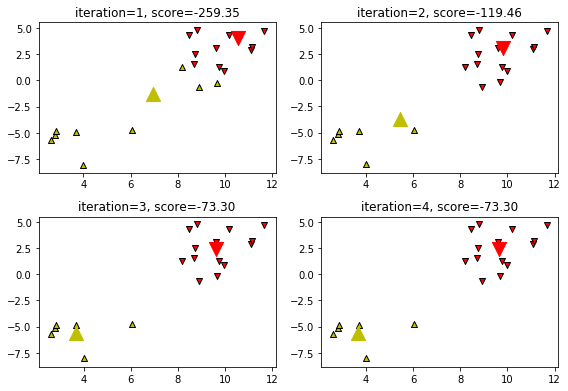

In [24]:
X, _ = make_blobs(n_samples=20, random_state=4)

def plot_KMeans(n):
    model = KMeans(n_clusters=2, init="random", n_init=1, max_iter=n, random_state=8).fit(X)
    c0, c1 = model.cluster_centers_
    plt.scatter(X[model.labels_ == 0, 0], X[model.labels_ == 0, 1], marker='v', facecolor='r', edgecolors='k')
    plt.scatter(X[model.labels_ == 1, 0], X[model.labels_ == 1, 1], marker='^', facecolor='y', edgecolors='k')
    plt.scatter(c0[0], c0[1], marker='v', c="r", s=200)
    plt.scatter(c1[0], c1[1], marker='^', c="y", s=200)
    plt.grid(False)
    plt.title("iteration={}, score={:5.2f}".format(n, model.score(X)))

plt.figure(figsize=(8, 8))
plt.subplot(321)
plot_KMeans(1)
plt.subplot(322)
plot_KMeans(2)
plt.subplot(323)
plot_KMeans(3)
plt.subplot(324)
plot_KMeans(4)
plt.tight_layout()
plt.show()

## Kmeans에 사용되는 컬럼

"genre_Drama", "genre_Comedy", "genre_Thriller", "genre_Romance", "genre_Action", "genre_Horror", "genre_Crime", "genre_Documentary", "genre_Adventure", "genre_Science Fiction", "genre_Family", "genre_Mystery", "genre_Fantasy", "genre_Animation", "genre_Foreign", "cast_Bess Flowers", "cast_Christopher Lee", "cast_John Wayne", "cast_Samuel L. Jackson", "cast_Gérard Depardieu", "cast_Michael Caine", "cast_John Carradine", "cast_Jackie Chan", "cast_Donald Sutherland", "cast_Frank Welker", "cast_Robert De Niro", "cast_Danny Trejo", "cast_Steve Buscemi", "cast_Irving Bacon", "cast_John Goodman", "cast_Christopher Walken", "cast_Danny Glover", "cast_Dennis Hopper", "cast_Susan Sarandon", "cast_John Hurt", "cast_Eric Roberts", "cast_Bruce Willis", "cast_Malcolm McDowell", "cast_Harvey Keitel", "cast_Willem Dafoe", "cast_Anthony Quinn", "cast_Keith David", "cast_Donald Pleasence", "cast_Stellan Skarsgård", "cast_Morgan Freeman", "cast_Whoopi Goldberg", "cast_Max von Sydow", "cast_Robert Duvall", "cast_Charles Lane", "cast_James Franco", "cast_Robin Williams", "cast_Nicolas Cage", "cast_Christopher Plummer", "cast_Alec Baldwin", "cast_Christopher Lloyd", "cast_Liam Neeson", "cast_Keenan Wynn", "cast_Vincent Price", "cast_Harry Dean Stanton", "cast_John Turturro", "cast_John Leguizamo", "cast_Ward Bond", "cast_Gene Hackman", "cast_James Earl Jones", "cast_Brian Cox", "cast_M. Emmet Walsh", "cast_Stanley Tucci", "cast_Ben Kingsley", "cast_Dick Miller", "cast_John George", "cast_Jim Broadbent", "cast_John Cusack", "cast_J.K. Simmons", "cast_Martin Sheen", "cast_Lance Henriksen", "cast_James Caan", "cast_Forest Whitaker", "cast_Peter Stormare", "cast_Burt Reynolds", "cast_James Mason", "cast_Wallace Shawn", "cast_Helen Mirren", "cast_Robert Mitchum", "cast_James Stewart", "cast_Bette Davis", "cast_Ed Harris", "cast_Woody Harrelson", "cast_Ron Perlman", "cast_Richard Jenkins", "cast_William H. Macy", "cast_Rutger Hauer", "cast_Mickey Rooney", "cast_Michael Ironside", "cast_Dan Aykroyd", "cast_Udo Kier", "cast_Henry Fonda", "cast_Boris Karloff", "cast_Tom Hanks", "cast_Paul Giamatti", "cast_Jeff Bridges", "cast_Ned Beatty", "cast_Lionel Barrymore", "cast_Anthony Hopkins", "cast_Christian Slater", "cast_Michael Gambon", "cast_Bruce Dern", "cast_Ray Milland", "cast_Grey Griffin", "cast_Val Kilmer", "cast_James Woods", "cast_Sylvester Stallone", "cast_Robert Downey Jr.", "cast_Nick Nolte", "cast_Vanessa Redgrave", "cast_Ernest Borgnine", "cast_Robert Forster", "cast_Burt Lancaster", "cast_Danny DeVito", "cast_Charles Durning", "cast_Johnny Depp", "cast_Ray Liotta", "cast_Peter Cushing", "cast_Matt Damon", "cast_Mark Strong", "cast_Henry O'Neill", "cast_Rip Torn", "cast_David Strathairn", "cast_Christopher McDonald", "cast_Roddy McDowall", "cast_John Malkovich", "cast_William Hurt", "cast_John Cleese", "cast_Charlton Heston", "cast_Tom Wilkinson", "cast_Antonio Banderas", "cast_Sigourney Weaver", "cast_Laurence Fishburne", "cast_Catherine Deneuve", "cast_Shelley Winters", "cast_Kris Kristofferson", "cast_Jeff Bennett", "cast_Orson Welles", "cast_Kirk Douglas", "cast_Julianne Moore", "cast_Meryl Streep", "cast_Alfred Molina", "cast_Alan Arkin", "cast_Isabelle Huppert", "cast_Dolph Lundgren", "cast_Bill Murray", "cast_Ving Rhames", "cast_Stephen Tobolowsky", "cast_Marcello Mastroianni", "cast_Cary Grant", "cast_Jim Cummings", "cast_Tom Arnold", "cast_Ben Stiller", "cast_Michael Madsen", "cast_Dustin Hoffman", "cast_Rod Steiger", "cast_Paul Fix", "cast_Reginald Owen", "cast_Frank Faylen", "cast_Buster Keaton", "cast_George Sanders", "cast_Sam Neill", "cast_Clint Howard", "cast_Keanu Reeves", "cast_James Remar", "cast_Kathy Bates", "cast_Joss Ackland", "cast_Paul Newman", "cast_Billy Zane", "cast_Raymond Burr", "cast_Humphrey Bogart", "cast_Tom Sizemore", "cast_Kevin Bacon", "cast_Jeff Goldblum", "cast_John C. Reilly", "cast_Dean Stockwell", "cast_Clint Eastwood", "cast_John Heard", "cast_Paul Guilfoyle", "cast_Patrick Stewart", "cast_Dennis Quaid", "cast_Bruce Davison", "cast_Brad Dourif", "cast_Tomás Milián", "cast_Alan Hale", "cast_Barbara Stanwyck", "cast_Charles Bronson", "cast_Edward G. Robinson", "cast_Kevin Pollak", "cast_Sean Bean", "cast_Richard Riehle", "cast_Cloris Leachman", "cast_Brad Pitt", "cast_Geraldine Chaplin", "cast_Michel Piccoli", "cast_George Kennedy", "cast_Oliver Platt", "cast_Gino Corrado", "cast_Joan Crawford", "cast_James Flavin", "cast_J. Carrol Naish", "cast_Mary Steenburgen", "cast_Dermot Mulroney", "cast_Sean Connery", "cast_Liev Schreiber", "cast_Bruce Greenwood", "cast_Lin Shaye", "cast_Ewan McGregor", "cast_Randy Quaid", "cast_Bill Nighy", "cast_Luis Guzmán", "cast_Michael Shannon", "cast_Joseph Crehan", "cast_Charlotte Rampling", "cast_Tim Roth", "cast_Nicole Kidman", "cast_Bill Pullman", "cast_Jim Belushi", "cast_Beth Grant", "cast_Om Puri", "cast_Stephen Root", "cast_Beau Bridges", "cast_Stacy Keach", "cast_Harry Morgan", "cast_David Carradine", "cast_Robert Taylor", "cast_Jon Voight", "cast_Harrison Ford", "cast_Kiefer Sutherland", "cast_Jeffrey Tambor", "cast_Anjelica Huston", "cast_Bill Paxton", "cast_Brian Dennehy", "cast_Ian Holm", "cast_James Hong", "cast_James Garner", "cast_Heather Graham", "cast_Mickey Rourke", "cast_Ian Wolfe", "cast_Sam Rockwell", "cast_Gary Cooper", "cast_Elisha Cook Jr.", "cast_Timothy Spall", "cast_Ray Teal", "cast_Randolph Scott", "cast_Patricia Clarkson", "cast_Walter Matthau", "cast_Jack Lemmon", "cast_Sharon Stone", "cast_John Travolta", "cast_Colleen Camp", "cast_Robert Loggia", "cast_Seymour Cassel", "cast_James Coburn", "cast_Kathleen Freeman", "cast_Sam Shepard", "cast_Ed Lauter", "cast_Franco Nero", "cast_Tom Skerritt", "cast_Russell Hicks", "cast_Akshay Kumar", "cast_Daryl Hannah", "cast_Ciarán Hinds", "cast_Sean Penn", "cast_Helena Bonham Carter", "cast_Jack Nicholson", "cast_Andy García", "cast_Bruce McGill", "cast_John Gielgud", "cast_Vincent D'Onofrio", "cast_Ethan Hawke", "cast_Jack Palance", "cast_Jennifer Tilly", "cast_Cary Elwes", "cast_John Lithgow", "cast_Charlie Sheen", "cast_Tony Curtis", "cast_Robert Patrick", "cast_Bert Moorhouse", "cast_Myrna Loy", "cast_Herbert Lom", "cast_Amitabh Bachchan", "cast_Burgess Meredith", "cast_Pierce Brosnan", "cast_Bob Hoskins", "cast_James Cromwell", "cast_Kevin Spacey", "cast_Gabriel Byrne", "cast_Woody Allen", "cast_Gary Busey", "cast_Brendan Gleeson", "cast_Matthew Lillard", "cast_Rosario Dawson", "cast_Elias Koteas", "cast_Gary Oldman", "cast_Billy Bob Thornton", "cast_Naomi Watts", "cast_Michael McKean", "cast_Shirley MacLaine", "cast_William Holden", "cast_Eli Wallach", "cast_William Demarest", "cast_Donald Crisp", "cast_Lon Chaney Jr.", "cast_Bing Crosby", "cast_Glenn Ford", "cast_Anupam Kher", "cast_Jean-Claude Van Damme", "cast_Richard Dreyfuss", "cast_Marisa Tomei", "cast_Marc Lawrence", "cast_Jonathan Pryce", "cast_Jack Black", "cast_Jack Warden", "cast_Joan Cusack", "cast_Patton Oswalt", "cast_Ernie Hudson", "cast_Kurt Russell", "cast_Sean Astin", "cast_Tom Berenger", "cast_Akim Tamiroff", "cast_Peter Lorre", "cast_John Qualen", "cast_Trevor Howard", "cast_John Mills", "cast_George Chandler", "cast_James Cagney", "cast_Frank McHugh", "cast_David Koechner", "cast_Addison Richards", "cast_John DiMaggio", "cast_Selmer Jackson", "cast_Shah Rukh Khan", "cast_Steve Martin", "cast_Janeane Garofalo", "cast_Ellen Burstyn", "cast_Michael Rapaport", "cast_Philip Baker Hall", "cast_Tim Curry", "cast_Chris Rock", "cast_Tommy Lee Jones", "cast_Drew Barrymore", "cast_Gina Gershon", "cast_Jeff Daniels", "cast_William Shatner", "cast_Elijah Wood", "cast_Jason Robards", "cast_Ed Begley Jr.", "cast_Tilda Swinton", "cast_Robert Ryan", "cast_David Cross", "cast_Clark Gable", "cast_Paul Harvey", "cast_Spencer Tracy", "cast_David Niven", "cast_Byron Foulger", "cast_Walter Brennan", "cast_Karen Black", "cast_Charlie Chaplin", "cast_Robert Wagner", "cast_Lam Suet", "cast_Al Pacino", "cast_Xander Berkeley", "cast_Matthew Modine", "cast_Paul Rudd", "cast_Maggie Smith", "cast_Parker Posey", "cast_Glenn Close", "cast_Bruce Campbell", "cast_Jeremy Irons", "cast_Cuba Gooding Jr.", "cast_Philip Seymour Hoffman", "cast_Allison Janney", "cast_David Warner", "cast_Octavia Spencer", "cast_Sam Harris", "cast_Gregory Peck", "cast_Frank Sinatra", "cast_J. Farrell MacDonald", "cast_Richard Widmark", "cast_Justin Long", "cast_Paresh Rawal", "cast_Paul Sorvino", "cast_Clancy Brown", "cast_Kristin Scott Thomas", "cast_David Thewlis", "cast_Elliott Gould", "cast_Luke Wilson", "cast_Kevin Corrigan", "cast_Aidan Quinn", "cast_Ralph Fiennes", "cast_Kevin Costner", "cast_Colin Firth", "cast_Tim Robbins", "cast_Stephen Rea", "cast_Tara Strong", "cast_Toby Jones", "cast_John Rhys-Davies", "cast_Martin Balsam", "cast_Joseph Cotten", "cast_Ann Doran", "cast_Doris Lloyd", "cast_Dennis O'Keefe", "cast_Vinnie Jones", "cast_Tom Kenny", "cast_Eugene Levy", "cast_Miriam Margolyes", "cast_Frank Langella", "cast_Salma Hayek", "cast_Matt Dillon", "cast_Owen Wilson", "cast_Scarlett Johansson", "cast_Joe Pantoliano", "cast_Jason Flemyng", "cast_Richard Gere", "cast_Catherine Keener", "cast_Scott Glenn", "cast_Rosanna Arquette", "cast_Juliette Binoche", "cast_William Sadler", "cast_Jeff Corey", "cast_Charles Dance", "cast_Kevin Michael Richardson", "cast_Ellen Corby", "cast_Ginger Rogers", "cast_Seth Green", "cast_Harry Andrews", "cast_Denholm Elliott", "cast_Chishu Ryu", "cast_Will Ferrell", "cast_Allen Jenkins", "cast_Jeremy Piven", "cast_Dan Hedaya", "cast_Edward Herrmann", "cast_Denis Leary", "cast_Faye Dunaway", "cast_Julia Roberts", "cast_Peter Coyote", "cast_Peter Boyle", "cast_Robert Redford", "cast_Michael Gough", "cast_Ben Affleck", "cast_Jean Reno", "cast_Rob Paulsen", "cast_Arnold Schwarzenegger", "cast_Michael Lerner", "cast_Michael Paré", "cast_Fred Ward", "cast_Marcia Gay Harden", "cast_Hal Holbrook", "cast_Vernon Dobtcheff", "cast_Jane Fonda", "cast_William Schallert", "cast_Eddie Albert", "cast_Peter O'Toole", "cast_Cameron Mitchell", "cast_C. Aubrey Smith", "cast_Sig Ruman", "cast_Walter Pidgeon", "cast_Vittorio Gassman", "cast_Jack Elam", "cast_Michael Hordern", "cast_Oliver Reed", "cast_Klaus Kinski", "cast_Cate Blanchett", "cast_Morris Ankrum", "cast_Judi Dench", "cast_Anne Bancroft", "cast_Maury Chaykin", "cast_Christina Ricci", "cast_Giancarlo Esposito", "cast_Jennifer Jason Leigh", "cast_Joe Mantegna", "cast_Mike Starr", "cast_George Clooney", "cast_Bob Balaban", "cast_Michael York", "cast_Stephen Lang", "cast_Tim Blake Nelson", "cast_Stan Lee", "cast_Peter Fonda", "cast_Kevin Kline", "cast_Carla Gugino", "cast_Miranda Richardson", "cast_Toni Collette", "cast_Matthew Broderick", "cast_Robert Englund", "cast_Geoffrey Lewis", "cast_Stephen McHattie", "cast_Debbie Reynolds", "cast_Adrien Brody", "cast_Angela Lansbury", "cast_Barbara Hershey", "cast_Pam Grier", "cast_Milton Kibbee", "cast_Fred MacMurray", "cast_Don Beddoe", "cast_Basil Rathbone", "cast_Samuel S. Hinds", "cast_Mary Gordon", "cast_Sammo Hung", "cast_Claudia Cardinale", "cast_Fred Willard", "cast_Joan Blondell", "cast_Sarah Silverman", "cast_Naseeruddin Shah", "cast_Simon Yam", "cast_Wesley Snipes", "cast_Robbie Coltrane", "cast_David Paymer", "cast_Leslie Nielsen", "cast_Winona Ryder", "cast_Molly Shannon", "cast_Cheech Marin", "cast_Carol Kane", "cast_Martin Landau", "cast_Denzel Washington", "cast_Alec Guinness", "cast_Steven Seagal", "cast_Caroline Aaron", "cast_Paul Dooley", "cast_Michael Keaton", "cast_Sam Elliott", "cast_Harry Carey, Jr.", "cast_Alain Delon", "cast_Peter Sellers", "cast_Agnes Moorehead", "cast_Dana Andrews", "cast_Gene Lockhart", "cast_John Ridgely", "cast_John Ireland", "cast_Sidney Poitier", "cast_Eddie Marsan", "cast_Judy Greer", "cast_Lewis Stone", "cast_Mark Ruffalo", "cast_Douglass Dumbrille", "cast_John C. McGinley", "cast_Emma Thompson", "cast_Lili Taylor", "cast_Chris Cooper", "cast_Terrence Howard", "cast_Mel Gibson", "cast_Uma Thurman", "cast_Adam Sandler", "cast_Steve Zahn", "cast_Don Cheadle", "cast_Dylan Baker", "cast_Tom Cruise", "cast_Mark Hamill", "cast_Ray Winstone", "cast_Chevy Chase", "cast_Anthony LaPaglia", "cast_Thomas Kretschmann", "cast_Terence Stamp", "cast_Larry Miller", "cast_Jeanne Moreau", "cast_Lee Phelps", "cast_Douglas Fowley", "cast_Barton MacLane", "cast_Thomas Mitchell", "cast_Edward Brophy", "cast_Van Johnson", "cast_Giovanni Ribisi", "cast_Lee J. Cobb", "cast_Bobby Cannavale", "cast_Andy Lau", "cast_Elizabeth Banks", "cast_Bill Hader", "cast_John Ratzenberger", "cast_Diane Keaton", "cast_Michael Douglas", "cast_Richard Harris", "cast_Richard Schiff", "cast_F. Murray Abraham", "cast_Juliette Lewis", "cast_Jean-Paul Belmondo", "cast_Josh Brolin", "cast_William Forsythe", "cast_Treat Williams", "cast_Diane Lane", "cast_James Le Gros", "cast_Kevin Smith", "cast_Keith Carradine", "cast_Jon Polito", "cast_Teri Garr", "cast_Isabella Rossellini", "cast_Carrie Fisher", "cast_Peter Falk", "cast_Crispin Glover", "cast_Jane Lynch", "cast_Ben Johnson", "cast_Sterling Holloway", "cast_Werner Herzog", "cast_Penélope Cruz", "cast_Leo White", "cast_Jane Darwell", "cast_Charles Middleton", "cast_Alan Mowbray", "cast_Wade Boteler", "cast_Charles Trowbridge", "cast_Karl Malden", "cast_Alan Napier", "cast_Peter Ustinov", "cast_Jim Backus", "cast_Burt Young", "cast_Whit Bissell", "cast_Richard Jaeckel", "cast_Jerry Lewis", "cast_Nestor Paiva", "cast_Alberto Sordi", "cast_Marion Cotillard", "cast_Fred Tatasciore", "cast_Kirsten Dunst", "cast_Ann-Margret", "cast_Alan Cumming", "cast_Alan Rickman", "cast_Jon Gries", "cast_Michael Sheen", "cast_John Saxon", "cast_John Savage", "cast_Melissa Leo", "cast_David Arquette", "cast_Martin Scorsese", "cast_Mark Wahlberg", "cast_Jared Harris", "cast_Virginia Madsen", "cast_Matthew McConaughey", "cast_Michael Lonsdale", "cast_Rob Lowe", "cast_Cameron Diaz", "cast_Dabney Coleman", "cast_Brion James", "cast_Jon Lovitz", "cast_Colm Meaney", "cast_Tracey Walter", "cast_Ray Wise", "cast_Bela Lugosi", "cast_Frank Puglia", "cast_Marcel Dalio", "cast_Olin Howland", "cast_Charles Halton", "cast_Regis Toomey", "cast_Robert Warwick", "cast_Rock Hudson", "cast_John McIntire", "cast_Omar Sharif", "cast_Arthur Kennedy", "cast_Henry Silva", "cast_Jet Li", "cast_John Litel", "cast_Donald Meek", "cast_Clarence Muse", "cast_Dean Martin", "cast_Josh Lucas", "cast_Anthony Wong", "cast_Lee Marvin", "cast_Louise Beavers", "cast_Bud Spencer", "cast_Tadanobu Asano", "cast_Kristen Wiig", "cast_Sophia Loren", "cast_Demi Moore", "cast_Michelle Pfeiffer", "cast_Ian McKellen", "cast_Gwyneth Paltrow", "cast_David Ogden Stiers", "cast_Philippe Noiret", "cast_Steve Coogan", "cast_Pruitt Taylor Vince", "cast_Jude Law", "cast_Jason Isaacs", "cast_George Segal", "cast_Colin Farrell", "cast_Viggo Mortensen", "cast_Armand Assante", "cast_Blythe Danner", "cast_Stephen Fry", "cast_Lambert Wilson", "cast_Tom Dugan", "cast_Richard E. Grant", "cast_Dub Taylor", "cast_Laura Dern", "cast_Dom DeLuise", "cast_Edmond O'Brien", "cast_Lyle Talbot", "cast_Peter Lawford", "cast_Jerome Cowan", "cast_Harry Davenport", "cast_Larry Steers", "cast_Edward Arnold", "cast_Grant Mitchell", "cast_George Irving", "cast_Queen Latifah", "cast_Derek Jacobi", "cast_Virginia Brissac", "cast_Lee Van Cleef", "cast_Royal Dano", "cast_Lochlyn Munro", "cast_James Marsden", "cast_Mathieu Amalric", "cast_Dennis Haysbert", "cast_Greg Kinnear", "cast_Mark Boone Junior", "cast_Pete Postlethwaite", "cast_Eric Stoltz", "cast_Anne Heche", "cast_Eddie Murphy", "cast_Timothy Hutton", "cast_Michael Biehn", "cast_Laura Linney", "cast_Jeffrey Combs", "cast_Marlon Brando", "cast_Donal Logue", "cast_Lauren Bacall", "cast_Jean Rochefort", "cast_Elizabeth Taylor", "cast_André Dussollier", "cast_Lloyd Bridges", "cast_Roy Scheider", "cast_Nastassja Kinski", "cast_Paolo Villaggio", "cast_Frankie Faison", "cast_Mel Blanc", "cast_Til Schweiger", "cast_Rachel Weisz", "cast_Thomas Jane", "cast_Fred Astaire", "cast_Charles Boyer", "cast_Harry Strang", "cast_Monte Blue", "cast_Laurence Olivier", "cast_Edmund Mortimer", "cast_Harry Hayden", "cast_Lane Chandler", "cast_Frank Mayo", "cast_Brian Keith", "cast_Eddie Izzard", "cast_Viola Davis", "cast_Robert Barrat", "cast_Fredric March", "cast_Ryan Reynolds", "cast_Barbara Hale", "cast_Gian Maria Volonté", "cast_Grady Sutton", "cast_Seth Rogen", "cast_Salman Khan", "cast_Jim Carrey", "cast_Will Patton", "cast_Brendan Fraser", "cast_Jean-Louis Trintignant", "cast_Alfre Woodard", "cast_Christian Bale", "cast_Benicio del Toro", "cast_Michael Clarke Duncan", "cast_Rob Schneider", "cast_Pat Hingle", "cast_Frances McDormand", "cast_Mia Farrow", "cast_Ellen Barkin", "cast_Héctor Elizondo", "cast_Tony Shalhoub", "cast_James Whitmore", "cast_Stephen Dorff", "cast_James Russo", "cast_George C. Scott", "cast_Vince Vaughn", "cast_Clive Owen", "cast_Ugo Tognazzi", "cast_Lukas Haas", "cast_Dee Wallace", "cast_Emmett Vogan", "cast_Walter Sande", "cast_Ava Gardner", "cast_Frank Reicher", "cast_Cedric Hardwicke", "cast_Beulah Bondi", "cast_Guy Kibbee", "cast_Leo Gorcey", "cast_James Gleason", "cast_John Hoyt", "cast_Una Merkel", "cast_Eleanor Parker", "cast_Ron Livingston", "cast_Charles McGraw", "cast_Spencer Charters", "cast_Will Wright", "cast_Geoffrey Rush", "cast_Jacqueline Bisset", "cast_Ren Osugi", "cast_Andy Serkis", "cast_Kane Hodder", "cast_Ralph Richardson", "cast_John Miljan", "cast_Richard Kind", "cast_Barry Sullivan", "cast_Jason Bateman", "cast_Anthony Mackie", "cast_Kareena Kapoor", "cast_Priyanka Chopra", "cast_Masako Nozawa", "cast_Philip Ettington", "cast_Margo Martindale", "cast_Kevin Dunn", "cast_L.Q. Jones", "cast_Melanie Griffith", "cast_David Morse", "cast_Clifton Collins Jr", "cast_Mira Sorvino", "cast_Vivica A. Fox", "cast_John Hawkes", "cast_Frank Mills", "cast_James Rebhorn", "cast_John Candy", "cast_Michael Rooker", "cast_Richard Masur", "cast_Katharine Hepburn", "cast_Toshirō Mifune", "cast_Kim Basinger", "cast_Guy Pearce", "cast_Catherine O'Hara", "cast_Louis Gossett, Jr.", "cast_Michael Murphy", "cast_Gary Cole", "cast_Rhys Ifans", "cast_Charles Laughton", "cast_Cecil Kellaway", "cast_Robert Vaughn", "cast_E.E. Clive", "cast_Stuart Holmes", "cast_Claude Rains", "cast_Walter Huston", "cast_Holmes Herbert", "cast_Harold Miller", "cast_Steven Geray", "cast_Herbert Marshall", "cast_Wallace Ford", "cast_Melvyn Douglas", "cast_Harry Cording", "cast_Lucille Ball", "cast_Robert Morley", "cast_Huntz Hall", "cast_Joe Sawyer", "cast_Charlize Theron", "cast_C. Thomas Howell", "cast_Michael Peña", "cast_Ed Asner", "cast_Brian Donlevy", "cast_Dean Jagger", "cast_Jason Statham", "cast_Alan Bates", "cast_Ian McShane", "cast_Johnny Lever", "cast_Bernard Blier", "cast_Ajay Devgn", "cast_Natalie Portman", "cast_Hank Azaria", "cast_Bob Gunton", "cast_James Gandolfini", "cast_Kenneth Branagh", "cast_Hugo Weaving", "cast_Peter Sarsgaard", "cast_Charles S. Dutton", "cast_Matt Frewer", "cast_Jason Alexander", "cast_Vincent Cassel", "cast_Ron Jeremy", "cast_Danny Aiello", "cast_Eric Idle", "cast_Angelina Jolie", "cast_Billy Crystal", "cast_Richard Anderson", "cast_Daniel Craig", "cast_Jean-Claude Brialy", "cast_Peter Gallagher", "cast_Sean Young", "cast_James Fox", "cast_Moroni Olsen", "cast_Ralph Bellamy", "cast_Lou Diamond Phillips", "cast_Mary Kay Place", "cast_Ingrid Bergman", "cast_Mike Mazurki", "cast_Emory Parnell", "cast_Leon Ames", "cast_Nigel Bruce", "cast_Reginald Denny", "cast_William Powell", "cast_Brooks Benedict", "cast_Pierre Watkin", "cast_Henry Stephenson", "cast_Will Arnett", "cast_Kathy Baker", "cast_Robert Young", "cast_Mae Marsh", "cast_Emily Watson", "cast_Lucy Liu", "cast_Danny Huston", "cast_Sid Haig", "cast_Fernando Rey", "cast_Takashi Shimura", "cast_Mary Field", "cast_Maria Bello", "cast_Amy Adams", "cast_Patrick Warburton", "cast_Dakota Fanning", "cast_Yuen Biao", "cast_Michael Nyqvist", "cast_Willard Robertson", "cast_Simon Pegg", "cast_Daniel Brühl", "cast_Jonah Hill", "cast_R. Lee Ermey", "cast_William Fichtner", "cast_Famke Janssen", "cast_Michael J. Fox", "cast_John Diehl", "cast_Scott Wilson", "cast_Cary-Hiroyuki Tagawa", "cast_Olympia Dukakis", "cast_David Keith", "cast_Beverly D'Angelo", "cast_Sandra Bullock", "cast_Tom Lister Jr.", "cast_Kevin McCarthy", "cast_Stockard Channing", "cast_Shirley Henderson", "cast_Jürgen Prochnow", "cast_Rade Serbedzija", "cast_Griffin Dunne", "cast_Tony Todd", "cast_Jamie Lee Curtis", "cast_Reese Witherspoon", "cast_Grace Zabriskie", "cast_Bill Moseley", "cast_Patrick Bauchau", "cast_Strother Martin", "cast_Adam Scott", "cast_Leslie Phillips", "cast_Sissy Spacek", "cast_Eric Tsang", "cast_Murray Alper", "cast_Chill Wills", "cast_Cyril Ring", "cast_Billy Bevan", "cast_Joel McCrea", "cast_George Davis", "cast_George Tobias", "cast_Pat Flaherty", "cast_Edgar Buchanan", "cast_Rhys Williams", "cast_Bernard Lee", "cast_Janet Leigh", "cast_Cyril Cusack", "cast_Lionel Stander", "cast_Susumu Terajima", "cast_Giuliano Gemma", "cast_Frank Ferguson", "cast_Richard Pryor", "cast_John Michael Higgins", "cast_Missi Pyle", "cast_Jonathan Hale", "cast_Alan Tudyk", "cast_Adolfo Celi", "cast_Amy Poehler", "cast_Mike Epps", "cast_Hugh Jackman", "cast_Rachael Leigh Cook", "cast_Tchéky Karyo", "cast_Kate Winslet", "cast_Steve Guttenberg", "cast_Billy Connolly", "cast_Joseph Gordon-Levitt", "cast_John Carroll Lynch", "cast_James Cosmo", "cast_Jodie Foster", "cast_Kenneth Welsh", "cast_Dianne Wiest", "cast_Jessica Lange", "cast_Chloë Sevigny", "cast_Jason Lee", "cast_Maximilian Schell", "cast_Daniel Auteuil", "cast_Russell Crowe", "cast_Woody Strode", "cast_James Spader", "cast_Gary Lewis", "cast_Corbin Bernsen", "cast_George Buck Flower", "cast_Callum Keith Rennie", "cast_Lena Headey", "cast_Tom Selleck", "cast_Billy Gilbert", "cast_Warren Oates", "cast_Jeffrey Wright", "cast_Barry Corbin", "cast_Jamie Foxx", "cast_Cesar Romero", "cast_Halliwell Hobbes", "cast_Frank Wilcox", "cast_Mary Astor", "cast_Jack Mower", "cast_Frank Morgan", "cast_Leyland Hodgson", "cast_Louis Calhern", "cast_Eugene Pallette", "cast_Edward Gargan", "cast_William B. Davidson", "cast_John Doucette", "cast_Natasha Lyonne", "cast_Olivier Gourmet"

In [25]:
df=DataFrame(me, columns=["adult","runtime","vote_count","genre_Drama", "genre_Comedy", "genre_Thriller", "genre_Romance", "genre_Action", "genre_Horror", "genre_Crime", "genre_Documentary", "genre_Adventure", "genre_Science Fiction", "genre_Family", "genre_Mystery", "genre_Fantasy", "genre_Animation", "genre_Foreign", "cast_Bess Flowers", "cast_Christopher Lee", "cast_John Wayne", "cast_Samuel L. Jackson", "cast_Gérard Depardieu", "cast_Michael Caine", "cast_John Carradine", "cast_Jackie Chan", "cast_Donald Sutherland", "cast_Frank Welker", "cast_Robert De Niro", "cast_Danny Trejo", "cast_Steve Buscemi", "cast_Irving Bacon", "cast_John Goodman", "cast_Christopher Walken", "cast_Danny Glover", "cast_Dennis Hopper", "cast_Susan Sarandon", "cast_John Hurt", "cast_Eric Roberts", "cast_Bruce Willis", "cast_Malcolm McDowell", "cast_Harvey Keitel", "cast_Willem Dafoe", "cast_Anthony Quinn", "cast_Keith David", "cast_Donald Pleasence", "cast_Stellan Skarsgård", "cast_Morgan Freeman", "cast_Whoopi Goldberg", "cast_Max von Sydow", "cast_Robert Duvall", "cast_Charles Lane", "cast_James Franco", "cast_Robin Williams", "cast_Nicolas Cage", "cast_Christopher Plummer", "cast_Alec Baldwin", "cast_Christopher Lloyd", "cast_Liam Neeson", "cast_Keenan Wynn", "cast_Vincent Price", "cast_Harry Dean Stanton", "cast_John Turturro", "cast_John Leguizamo", "cast_Ward Bond", "cast_Gene Hackman", "cast_James Earl Jones", "cast_Brian Cox", "cast_M. Emmet Walsh", "cast_Stanley Tucci", "cast_Ben Kingsley", "cast_Dick Miller", "cast_John George", "cast_Jim Broadbent", "cast_John Cusack", "cast_J.K. Simmons", "cast_Martin Sheen", "cast_Lance Henriksen", "cast_James Caan", "cast_Forest Whitaker", "cast_Peter Stormare", "cast_Burt Reynolds", "cast_James Mason", "cast_Wallace Shawn", "cast_Helen Mirren", "cast_Robert Mitchum", "cast_James Stewart", "cast_Bette Davis", "cast_Ed Harris", "cast_Woody Harrelson", "cast_Ron Perlman", "cast_Richard Jenkins", "cast_William H. Macy", "cast_Rutger Hauer", "cast_Mickey Rooney", "cast_Michael Ironside", "cast_Dan Aykroyd", "cast_Udo Kier", "cast_Henry Fonda", "cast_Boris Karloff", "cast_Tom Hanks", "cast_Paul Giamatti", "cast_Jeff Bridges", "cast_Ned Beatty", "cast_Lionel Barrymore", "cast_Anthony Hopkins", "cast_Christian Slater", "cast_Michael Gambon", "cast_Bruce Dern", "cast_Ray Milland", "cast_Grey Griffin", "cast_Val Kilmer", "cast_James Woods", "cast_Sylvester Stallone", "cast_Robert Downey Jr.", "cast_Nick Nolte", "cast_Vanessa Redgrave", "cast_Ernest Borgnine", "cast_Robert Forster", "cast_Burt Lancaster", "cast_Danny DeVito", "cast_Charles Durning", "cast_Johnny Depp", "cast_Ray Liotta", "cast_Peter Cushing", "cast_Matt Damon", "cast_Mark Strong", "cast_Henry O'Neill", "cast_Rip Torn", "cast_David Strathairn", "cast_Christopher McDonald", "cast_Roddy McDowall", "cast_John Malkovich", "cast_William Hurt", "cast_John Cleese", "cast_Charlton Heston", "cast_Tom Wilkinson", "cast_Antonio Banderas", "cast_Sigourney Weaver", "cast_Laurence Fishburne", "cast_Catherine Deneuve", "cast_Shelley Winters", "cast_Kris Kristofferson", "cast_Jeff Bennett", "cast_Orson Welles", "cast_Kirk Douglas", "cast_Julianne Moore", "cast_Meryl Streep", "cast_Alfred Molina", "cast_Alan Arkin", "cast_Isabelle Huppert", "cast_Dolph Lundgren", "cast_Bill Murray", "cast_Ving Rhames", "cast_Stephen Tobolowsky", "cast_Marcello Mastroianni", "cast_Cary Grant", "cast_Jim Cummings", "cast_Tom Arnold", "cast_Ben Stiller", "cast_Michael Madsen", "cast_Dustin Hoffman", "cast_Rod Steiger", "cast_Paul Fix", "cast_Reginald Owen", "cast_Frank Faylen", "cast_Buster Keaton", "cast_George Sanders", "cast_Sam Neill", "cast_Clint Howard", "cast_Keanu Reeves", "cast_James Remar", "cast_Kathy Bates", "cast_Joss Ackland", "cast_Paul Newman", "cast_Billy Zane", "cast_Raymond Burr", "cast_Humphrey Bogart", "cast_Tom Sizemore", "cast_Kevin Bacon", "cast_Jeff Goldblum", "cast_John C. Reilly", "cast_Dean Stockwell", "cast_Clint Eastwood", "cast_John Heard", "cast_Paul Guilfoyle", "cast_Patrick Stewart", "cast_Dennis Quaid", "cast_Bruce Davison", "cast_Brad Dourif", "cast_Tomás Milián", "cast_Alan Hale", "cast_Barbara Stanwyck", "cast_Charles Bronson", "cast_Edward G. Robinson", "cast_Kevin Pollak", "cast_Sean Bean", "cast_Richard Riehle", "cast_Cloris Leachman", "cast_Brad Pitt", "cast_Geraldine Chaplin", "cast_Michel Piccoli", "cast_George Kennedy", "cast_Oliver Platt", "cast_Gino Corrado", "cast_Joan Crawford", "cast_James Flavin", "cast_J. Carrol Naish", "cast_Mary Steenburgen", "cast_Dermot Mulroney", "cast_Sean Connery", "cast_Liev Schreiber", "cast_Bruce Greenwood", "cast_Lin Shaye", "cast_Ewan McGregor", "cast_Randy Quaid", "cast_Bill Nighy", "cast_Luis Guzmán", "cast_Michael Shannon", "cast_Joseph Crehan", "cast_Charlotte Rampling", "cast_Tim Roth", "cast_Nicole Kidman", "cast_Bill Pullman", "cast_Jim Belushi", "cast_Beth Grant", "cast_Om Puri", "cast_Stephen Root", "cast_Beau Bridges", "cast_Stacy Keach", "cast_Harry Morgan", "cast_David Carradine", "cast_Robert Taylor", "cast_Jon Voight", "cast_Harrison Ford", "cast_Kiefer Sutherland", "cast_Jeffrey Tambor", "cast_Anjelica Huston", "cast_Bill Paxton", "cast_Brian Dennehy", "cast_Ian Holm", "cast_James Hong", "cast_James Garner", "cast_Heather Graham", "cast_Mickey Rourke", "cast_Ian Wolfe", "cast_Sam Rockwell", "cast_Gary Cooper", "cast_Elisha Cook Jr.", "cast_Timothy Spall", "cast_Ray Teal", "cast_Randolph Scott", "cast_Patricia Clarkson", "cast_Walter Matthau", "cast_Jack Lemmon", "cast_Sharon Stone", "cast_John Travolta", "cast_Colleen Camp", "cast_Robert Loggia", "cast_Seymour Cassel", "cast_James Coburn", "cast_Kathleen Freeman", "cast_Sam Shepard", "cast_Ed Lauter", "cast_Franco Nero", "cast_Tom Skerritt", "cast_Russell Hicks", "cast_Akshay Kumar", "cast_Daryl Hannah", "cast_Ciarán Hinds", "cast_Sean Penn", "cast_Helena Bonham Carter", "cast_Jack Nicholson", "cast_Andy García", "cast_Bruce McGill", "cast_John Gielgud", "cast_Vincent D'Onofrio", "cast_Ethan Hawke", "cast_Jack Palance", "cast_Jennifer Tilly", "cast_Cary Elwes", "cast_John Lithgow", "cast_Charlie Sheen", "cast_Tony Curtis", "cast_Robert Patrick", "cast_Bert Moorhouse", "cast_Myrna Loy", "cast_Herbert Lom", "cast_Amitabh Bachchan", "cast_Burgess Meredith", "cast_Pierce Brosnan", "cast_Bob Hoskins", "cast_James Cromwell", "cast_Kevin Spacey", "cast_Gabriel Byrne", "cast_Woody Allen", "cast_Gary Busey", "cast_Brendan Gleeson", "cast_Matthew Lillard", "cast_Rosario Dawson", "cast_Elias Koteas", "cast_Gary Oldman", "cast_Billy Bob Thornton", "cast_Naomi Watts", "cast_Michael McKean", "cast_Shirley MacLaine", "cast_William Holden", "cast_Eli Wallach", "cast_William Demarest", "cast_Donald Crisp", "cast_Lon Chaney Jr.", "cast_Bing Crosby", "cast_Glenn Ford", "cast_Anupam Kher", "cast_Jean-Claude Van Damme", "cast_Richard Dreyfuss", "cast_Marisa Tomei", "cast_Marc Lawrence", "cast_Jonathan Pryce", "cast_Jack Black", "cast_Jack Warden", "cast_Joan Cusack", "cast_Patton Oswalt", "cast_Ernie Hudson", "cast_Kurt Russell", "cast_Sean Astin", "cast_Tom Berenger", "cast_Akim Tamiroff", "cast_Peter Lorre", "cast_John Qualen", "cast_Trevor Howard", "cast_John Mills", "cast_George Chandler", "cast_James Cagney", "cast_Frank McHugh", "cast_David Koechner", "cast_Addison Richards", "cast_John DiMaggio", "cast_Selmer Jackson", "cast_Shah Rukh Khan", "cast_Steve Martin", "cast_Janeane Garofalo", "cast_Ellen Burstyn", "cast_Michael Rapaport", "cast_Philip Baker Hall", "cast_Tim Curry", "cast_Chris Rock", "cast_Tommy Lee Jones", "cast_Drew Barrymore", "cast_Gina Gershon", "cast_Jeff Daniels", "cast_William Shatner", "cast_Elijah Wood", "cast_Jason Robards", "cast_Ed Begley Jr.", "cast_Tilda Swinton", "cast_Robert Ryan", "cast_David Cross", "cast_Clark Gable", "cast_Paul Harvey", "cast_Spencer Tracy", "cast_David Niven", "cast_Byron Foulger", "cast_Walter Brennan", "cast_Karen Black", "cast_Charlie Chaplin", "cast_Robert Wagner", "cast_Lam Suet", "cast_Al Pacino", "cast_Xander Berkeley", "cast_Matthew Modine", "cast_Paul Rudd", "cast_Maggie Smith", "cast_Parker Posey", "cast_Glenn Close", "cast_Bruce Campbell", "cast_Jeremy Irons", "cast_Cuba Gooding Jr.", "cast_Philip Seymour Hoffman", "cast_Allison Janney", "cast_David Warner", "cast_Octavia Spencer", "cast_Sam Harris", "cast_Gregory Peck", "cast_Frank Sinatra", "cast_J. Farrell MacDonald", "cast_Richard Widmark", "cast_Justin Long", "cast_Paresh Rawal", "cast_Paul Sorvino", "cast_Clancy Brown", "cast_Kristin Scott Thomas", "cast_David Thewlis", "cast_Elliott Gould", "cast_Luke Wilson", "cast_Kevin Corrigan", "cast_Aidan Quinn", "cast_Ralph Fiennes", "cast_Kevin Costner", "cast_Colin Firth", "cast_Tim Robbins", "cast_Stephen Rea", "cast_Tara Strong", "cast_Toby Jones", "cast_John Rhys-Davies", "cast_Martin Balsam", "cast_Joseph Cotten", "cast_Ann Doran", "cast_Doris Lloyd", "cast_Dennis O'Keefe", "cast_Vinnie Jones", "cast_Tom Kenny", "cast_Eugene Levy", "cast_Miriam Margolyes", "cast_Frank Langella", "cast_Salma Hayek", "cast_Matt Dillon", "cast_Owen Wilson", "cast_Scarlett Johansson", "cast_Joe Pantoliano", "cast_Jason Flemyng", "cast_Richard Gere", "cast_Catherine Keener", "cast_Scott Glenn", "cast_Rosanna Arquette", "cast_Juliette Binoche", "cast_William Sadler", "cast_Jeff Corey", "cast_Charles Dance", "cast_Kevin Michael Richardson", "cast_Ellen Corby", "cast_Ginger Rogers", "cast_Seth Green", "cast_Harry Andrews", "cast_Denholm Elliott", "cast_Chishu Ryu", "cast_Will Ferrell", "cast_Allen Jenkins", "cast_Jeremy Piven", "cast_Dan Hedaya", "cast_Edward Herrmann", "cast_Denis Leary", "cast_Faye Dunaway", "cast_Julia Roberts", "cast_Peter Coyote", "cast_Peter Boyle", "cast_Robert Redford", "cast_Michael Gough", "cast_Ben Affleck", "cast_Jean Reno", "cast_Rob Paulsen", "cast_Arnold Schwarzenegger", "cast_Michael Lerner", "cast_Michael Paré", "cast_Fred Ward", "cast_Marcia Gay Harden", "cast_Hal Holbrook", "cast_Vernon Dobtcheff", "cast_Jane Fonda", "cast_William Schallert", "cast_Eddie Albert", "cast_Peter O'Toole", "cast_Cameron Mitchell", "cast_C. Aubrey Smith", "cast_Sig Ruman", "cast_Walter Pidgeon", "cast_Vittorio Gassman", "cast_Jack Elam", "cast_Michael Hordern", "cast_Oliver Reed", "cast_Klaus Kinski", "cast_Cate Blanchett", "cast_Morris Ankrum", "cast_Judi Dench", "cast_Anne Bancroft", "cast_Maury Chaykin", "cast_Christina Ricci", "cast_Giancarlo Esposito", "cast_Jennifer Jason Leigh", "cast_Joe Mantegna", "cast_Mike Starr", "cast_George Clooney", "cast_Bob Balaban", "cast_Michael York", "cast_Stephen Lang", "cast_Tim Blake Nelson", "cast_Stan Lee", "cast_Peter Fonda", "cast_Kevin Kline", "cast_Carla Gugino", "cast_Miranda Richardson", "cast_Toni Collette", "cast_Matthew Broderick", "cast_Robert Englund", "cast_Geoffrey Lewis", "cast_Stephen McHattie", "cast_Debbie Reynolds", "cast_Adrien Brody", "cast_Angela Lansbury", "cast_Barbara Hershey", "cast_Pam Grier", "cast_Milton Kibbee", "cast_Fred MacMurray", "cast_Don Beddoe", "cast_Basil Rathbone", "cast_Samuel S. Hinds", "cast_Mary Gordon", "cast_Sammo Hung", "cast_Claudia Cardinale", "cast_Fred Willard", "cast_Joan Blondell", "cast_Sarah Silverman", "cast_Naseeruddin Shah", "cast_Simon Yam", "cast_Wesley Snipes", "cast_Robbie Coltrane", "cast_David Paymer", "cast_Leslie Nielsen", "cast_Winona Ryder", "cast_Molly Shannon", "cast_Cheech Marin", "cast_Carol Kane", "cast_Martin Landau", "cast_Denzel Washington", "cast_Alec Guinness", "cast_Steven Seagal", "cast_Caroline Aaron", "cast_Paul Dooley", "cast_Michael Keaton", "cast_Sam Elliott", "cast_Harry Carey, Jr.", "cast_Alain Delon", "cast_Peter Sellers", "cast_Agnes Moorehead", "cast_Dana Andrews", "cast_Gene Lockhart", "cast_John Ridgely", "cast_John Ireland", "cast_Sidney Poitier", "cast_Eddie Marsan", "cast_Judy Greer", "cast_Lewis Stone", "cast_Mark Ruffalo", "cast_Douglass Dumbrille", "cast_John C. McGinley", "cast_Emma Thompson", "cast_Lili Taylor", "cast_Chris Cooper", "cast_Terrence Howard", "cast_Mel Gibson", "cast_Uma Thurman", "cast_Adam Sandler", "cast_Steve Zahn", "cast_Don Cheadle", "cast_Dylan Baker", "cast_Tom Cruise", "cast_Mark Hamill", "cast_Ray Winstone", "cast_Chevy Chase", "cast_Anthony LaPaglia", "cast_Thomas Kretschmann", "cast_Terence Stamp", "cast_Larry Miller", "cast_Jeanne Moreau", "cast_Lee Phelps", "cast_Douglas Fowley", "cast_Barton MacLane", "cast_Thomas Mitchell", "cast_Edward Brophy", "cast_Van Johnson", "cast_Giovanni Ribisi", "cast_Lee J. Cobb", "cast_Bobby Cannavale", "cast_Andy Lau", "cast_Elizabeth Banks", "cast_Bill Hader", "cast_John Ratzenberger", "cast_Diane Keaton", "cast_Michael Douglas", "cast_Richard Harris", "cast_Richard Schiff", "cast_F. Murray Abraham", "cast_Juliette Lewis", "cast_Jean-Paul Belmondo", "cast_Josh Brolin", "cast_William Forsythe", "cast_Treat Williams", "cast_Diane Lane", "cast_James Le Gros", "cast_Kevin Smith", "cast_Keith Carradine", "cast_Jon Polito", "cast_Teri Garr", "cast_Isabella Rossellini", "cast_Carrie Fisher", "cast_Peter Falk", "cast_Crispin Glover", "cast_Jane Lynch", "cast_Ben Johnson", "cast_Sterling Holloway", "cast_Werner Herzog", "cast_Penélope Cruz", "cast_Leo White", "cast_Jane Darwell", "cast_Charles Middleton", "cast_Alan Mowbray", "cast_Wade Boteler", "cast_Charles Trowbridge", "cast_Karl Malden", "cast_Alan Napier", "cast_Peter Ustinov", "cast_Jim Backus", "cast_Burt Young", "cast_Whit Bissell", "cast_Richard Jaeckel", "cast_Jerry Lewis", "cast_Nestor Paiva", "cast_Alberto Sordi", "cast_Marion Cotillard", "cast_Fred Tatasciore", "cast_Kirsten Dunst", "cast_Ann-Margret", "cast_Alan Cumming", "cast_Alan Rickman", "cast_Jon Gries", "cast_Michael Sheen", "cast_John Saxon", "cast_John Savage", "cast_Melissa Leo", "cast_David Arquette", "cast_Martin Scorsese", "cast_Mark Wahlberg", "cast_Jared Harris", "cast_Virginia Madsen", "cast_Matthew McConaughey", "cast_Michael Lonsdale", "cast_Rob Lowe", "cast_Cameron Diaz", "cast_Dabney Coleman", "cast_Brion James", "cast_Jon Lovitz", "cast_Colm Meaney", "cast_Tracey Walter", "cast_Ray Wise", "cast_Bela Lugosi", "cast_Frank Puglia", "cast_Marcel Dalio", "cast_Olin Howland", "cast_Charles Halton", "cast_Regis Toomey", "cast_Robert Warwick", "cast_Rock Hudson", "cast_John McIntire", "cast_Omar Sharif", "cast_Arthur Kennedy", "cast_Henry Silva", "cast_Jet Li", "cast_John Litel", "cast_Donald Meek", "cast_Clarence Muse", "cast_Dean Martin", "cast_Josh Lucas", "cast_Anthony Wong", "cast_Lee Marvin", "cast_Louise Beavers", "cast_Bud Spencer", "cast_Tadanobu Asano", "cast_Kristen Wiig", "cast_Sophia Loren", "cast_Demi Moore", "cast_Michelle Pfeiffer", "cast_Ian McKellen", "cast_Gwyneth Paltrow", "cast_David Ogden Stiers", "cast_Philippe Noiret", "cast_Steve Coogan", "cast_Pruitt Taylor Vince", "cast_Jude Law", "cast_Jason Isaacs", "cast_George Segal", "cast_Colin Farrell", "cast_Viggo Mortensen", "cast_Armand Assante", "cast_Blythe Danner", "cast_Stephen Fry", "cast_Lambert Wilson", "cast_Tom Dugan", "cast_Richard E. Grant", "cast_Dub Taylor", "cast_Laura Dern", "cast_Dom DeLuise", "cast_Edmond O'Brien", "cast_Lyle Talbot", "cast_Peter Lawford", "cast_Jerome Cowan", "cast_Harry Davenport", "cast_Larry Steers", "cast_Edward Arnold", "cast_Grant Mitchell", "cast_George Irving", "cast_Queen Latifah", "cast_Derek Jacobi", "cast_Virginia Brissac", "cast_Lee Van Cleef", "cast_Royal Dano", "cast_Lochlyn Munro", "cast_James Marsden", "cast_Mathieu Amalric", "cast_Dennis Haysbert", "cast_Greg Kinnear", "cast_Mark Boone Junior", "cast_Pete Postlethwaite", "cast_Eric Stoltz", "cast_Anne Heche", "cast_Eddie Murphy", "cast_Timothy Hutton", "cast_Michael Biehn", "cast_Laura Linney", "cast_Jeffrey Combs", "cast_Marlon Brando", "cast_Donal Logue", "cast_Lauren Bacall", "cast_Jean Rochefort", "cast_Elizabeth Taylor", "cast_André Dussollier", "cast_Lloyd Bridges", "cast_Roy Scheider", "cast_Nastassja Kinski", "cast_Paolo Villaggio", "cast_Frankie Faison", "cast_Mel Blanc", "cast_Til Schweiger", "cast_Rachel Weisz", "cast_Thomas Jane", "cast_Fred Astaire", "cast_Charles Boyer", "cast_Harry Strang", "cast_Monte Blue", "cast_Laurence Olivier", "cast_Edmund Mortimer", "cast_Harry Hayden", "cast_Lane Chandler", "cast_Frank Mayo", "cast_Brian Keith", "cast_Eddie Izzard", "cast_Viola Davis", "cast_Robert Barrat", "cast_Fredric March", "cast_Ryan Reynolds", "cast_Barbara Hale", "cast_Gian Maria Volonté", "cast_Grady Sutton", "cast_Seth Rogen", "cast_Salman Khan", "cast_Jim Carrey", "cast_Will Patton", "cast_Brendan Fraser", "cast_Jean-Louis Trintignant", "cast_Alfre Woodard", "cast_Christian Bale", "cast_Benicio del Toro", "cast_Michael Clarke Duncan", "cast_Rob Schneider", "cast_Pat Hingle", "cast_Frances McDormand", "cast_Mia Farrow", "cast_Ellen Barkin", "cast_Héctor Elizondo", "cast_Tony Shalhoub", "cast_James Whitmore", "cast_Stephen Dorff", "cast_James Russo", "cast_George C. Scott", "cast_Vince Vaughn", "cast_Clive Owen", "cast_Ugo Tognazzi", "cast_Lukas Haas", "cast_Dee Wallace", "cast_Emmett Vogan", "cast_Walter Sande", "cast_Ava Gardner", "cast_Frank Reicher", "cast_Cedric Hardwicke", "cast_Beulah Bondi", "cast_Guy Kibbee", "cast_Leo Gorcey", "cast_James Gleason", "cast_John Hoyt", "cast_Una Merkel", "cast_Eleanor Parker", "cast_Ron Livingston", "cast_Charles McGraw", "cast_Spencer Charters", "cast_Will Wright", "cast_Geoffrey Rush", "cast_Jacqueline Bisset", "cast_Ren Osugi", "cast_Andy Serkis", "cast_Kane Hodder", "cast_Ralph Richardson", "cast_John Miljan", "cast_Richard Kind", "cast_Barry Sullivan", "cast_Jason Bateman", "cast_Anthony Mackie", "cast_Kareena Kapoor", "cast_Priyanka Chopra", "cast_Masako Nozawa", "cast_Philip Ettington", "cast_Margo Martindale", "cast_Kevin Dunn", "cast_L.Q. Jones", "cast_Melanie Griffith", "cast_David Morse", "cast_Clifton Collins Jr", "cast_Mira Sorvino", "cast_Vivica A. Fox", "cast_John Hawkes", "cast_Frank Mills", "cast_James Rebhorn", "cast_John Candy", "cast_Michael Rooker", "cast_Richard Masur", "cast_Katharine Hepburn", "cast_Toshirō Mifune", "cast_Kim Basinger", "cast_Guy Pearce", "cast_Catherine O'Hara", "cast_Louis Gossett, Jr.", "cast_Michael Murphy", "cast_Gary Cole", "cast_Rhys Ifans", "cast_Charles Laughton", "cast_Cecil Kellaway", "cast_Robert Vaughn", "cast_E.E. Clive", "cast_Stuart Holmes", "cast_Claude Rains", "cast_Walter Huston", "cast_Holmes Herbert", "cast_Harold Miller", "cast_Steven Geray", "cast_Herbert Marshall", "cast_Wallace Ford", "cast_Melvyn Douglas", "cast_Harry Cording", "cast_Lucille Ball", "cast_Robert Morley", "cast_Huntz Hall", "cast_Joe Sawyer", "cast_Charlize Theron", "cast_C. Thomas Howell", "cast_Michael Peña", "cast_Ed Asner", "cast_Brian Donlevy", "cast_Dean Jagger", "cast_Jason Statham", "cast_Alan Bates", "cast_Ian McShane", "cast_Johnny Lever", "cast_Bernard Blier", "cast_Ajay Devgn", "cast_Natalie Portman", "cast_Hank Azaria", "cast_Bob Gunton", "cast_James Gandolfini", "cast_Kenneth Branagh", "cast_Hugo Weaving", "cast_Peter Sarsgaard", "cast_Charles S. Dutton", "cast_Matt Frewer", "cast_Jason Alexander", "cast_Vincent Cassel", "cast_Ron Jeremy", "cast_Danny Aiello", "cast_Eric Idle", "cast_Angelina Jolie", "cast_Billy Crystal", "cast_Richard Anderson", "cast_Daniel Craig", "cast_Jean-Claude Brialy", "cast_Peter Gallagher", "cast_Sean Young", "cast_James Fox", "cast_Moroni Olsen", "cast_Ralph Bellamy", "cast_Lou Diamond Phillips", "cast_Mary Kay Place", "cast_Ingrid Bergman", "cast_Mike Mazurki", "cast_Emory Parnell", "cast_Leon Ames", "cast_Nigel Bruce", "cast_Reginald Denny", "cast_William Powell", "cast_Brooks Benedict", "cast_Pierre Watkin", "cast_Henry Stephenson", "cast_Will Arnett", "cast_Kathy Baker", "cast_Robert Young", "cast_Mae Marsh", "cast_Emily Watson", "cast_Lucy Liu", "cast_Danny Huston", "cast_Sid Haig", "cast_Fernando Rey", "cast_Takashi Shimura", "cast_Mary Field", "cast_Maria Bello", "cast_Amy Adams", "cast_Patrick Warburton", "cast_Dakota Fanning", "cast_Yuen Biao", "cast_Michael Nyqvist", "cast_Willard Robertson", "cast_Simon Pegg", "cast_Daniel Brühl", "cast_Jonah Hill", "cast_R. Lee Ermey", "cast_William Fichtner", "cast_Famke Janssen", "cast_Michael J. Fox", "cast_John Diehl", "cast_Scott Wilson", "cast_Cary-Hiroyuki Tagawa", "cast_Olympia Dukakis", "cast_David Keith", "cast_Beverly D'Angelo", "cast_Sandra Bullock", "cast_Tom Lister Jr.", "cast_Kevin McCarthy", "cast_Stockard Channing", "cast_Shirley Henderson", "cast_Jürgen Prochnow", "cast_Rade Serbedzija", "cast_Griffin Dunne", "cast_Tony Todd", "cast_Jamie Lee Curtis", "cast_Reese Witherspoon", "cast_Grace Zabriskie", "cast_Bill Moseley", "cast_Patrick Bauchau", "cast_Strother Martin", "cast_Adam Scott", "cast_Leslie Phillips", "cast_Sissy Spacek", "cast_Eric Tsang", "cast_Murray Alper", "cast_Chill Wills", "cast_Cyril Ring", "cast_Billy Bevan", "cast_Joel McCrea", "cast_George Davis", "cast_George Tobias", "cast_Pat Flaherty", "cast_Edgar Buchanan", "cast_Rhys Williams", "cast_Bernard Lee", "cast_Janet Leigh", "cast_Cyril Cusack", "cast_Lionel Stander", "cast_Susumu Terajima", "cast_Giuliano Gemma", "cast_Frank Ferguson", "cast_Richard Pryor", "cast_John Michael Higgins", "cast_Missi Pyle", "cast_Jonathan Hale", "cast_Alan Tudyk", "cast_Adolfo Celi", "cast_Amy Poehler", "cast_Mike Epps", "cast_Hugh Jackman", "cast_Rachael Leigh Cook", "cast_Tchéky Karyo", "cast_Kate Winslet", "cast_Steve Guttenberg", "cast_Billy Connolly", "cast_Joseph Gordon-Levitt", "cast_John Carroll Lynch", "cast_James Cosmo", "cast_Jodie Foster", "cast_Kenneth Welsh", "cast_Dianne Wiest", "cast_Jessica Lange", "cast_Chloë Sevigny", "cast_Jason Lee", "cast_Maximilian Schell", "cast_Daniel Auteuil", "cast_Russell Crowe", "cast_Woody Strode", "cast_James Spader", "cast_Gary Lewis", "cast_Corbin Bernsen", "cast_George Buck Flower", "cast_Callum Keith Rennie", "cast_Lena Headey", "cast_Tom Selleck", "cast_Billy Gilbert", "cast_Warren Oates", "cast_Jeffrey Wright", "cast_Barry Corbin", "cast_Jamie Foxx", "cast_Cesar Romero", "cast_Halliwell Hobbes", "cast_Frank Wilcox", "cast_Mary Astor", "cast_Jack Mower", "cast_Frank Morgan", "cast_Leyland Hodgson", "cast_Louis Calhern", "cast_Eugene Pallette", "cast_Edward Gargan", "cast_William B. Davidson", "cast_John Doucette", "cast_Natasha Lyonne", "cast_Olivier Gourmet"])

### index me['imdb_id']로 바꾸기

In [26]:
df.index=me['imdb_id'].values

In [27]:
df.isnull().sum()

adult                       0
runtime                     0
vote_count                  0
genre_Drama                 0
genre_Comedy                0
genre_Thriller              0
genre_Romance               0
genre_Action                0
genre_Horror                0
genre_Crime                 0
genre_Documentary           0
genre_Adventure             0
genre_Science Fiction       0
genre_Family                0
genre_Mystery               0
genre_Fantasy               0
genre_Animation             0
genre_Foreign               0
cast_Bess Flowers           0
cast_Christopher Lee        0
cast_John Wayne             0
cast_Samuel L. Jackson      0
cast_Gérard Depardieu       0
cast_Michael Caine          0
cast_John Carradine         0
cast_Jackie Chan            0
cast_Donald Sutherland      0
cast_Frank Welker           0
cast_Robert De Niro         0
cast_Danny Trejo            0
                           ..
cast_Maximilian Schell      0
cast_Daniel Auteuil         0
cast_Russe

### Inertia value를 이용한 적정 군집수 판단

In [28]:
ks=range(1,10)
inertias=[]

for k in ks:
    model=KMeans(n_clusters=k)
    model.fit(df)
    inertias.append(model.inertia_)

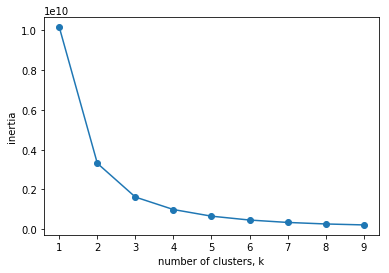

In [29]:
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## 결론 ) k=6으로 하기!!

### StandardScaler를 사용해서 스케일을 조정한 값으로 군집화

In [31]:
scaler=StandardScaler()
model=KMeans(n_clusters=6)
pipline=make_pipeline(scaler, model)
pipline.fit(df)
predict=pd.DataFrame(pipline.predict(df))
centroids=model.cluster_centers_
centroids

array([[ 0.        , -0.01432246, -0.24014196, ...,  1.29238028,
        -0.04382519, -0.04382519],
       [ 0.        ,  0.03768647, -0.06564835, ..., -0.00193843,
         0.0019454 ,  0.00456086],
       [ 0.        , -0.38379527,  1.205668  , ..., -0.03957637,
         0.01356834, -0.02469401],
       [ 0.        ,  0.0762666 , -0.25005447, ..., -0.03957637,
        -0.04382519, -0.04382519],
       [ 0.        ,  0.39521692, -0.22450154, ..., -0.03957637,
        -0.04382519, -0.04382519],
       [ 0.        , -0.22602472, -0.25807392, ...,  0.038053  ,
        -0.04382519, -0.04382519]])

In [32]:
predict.index=me['imdb_id'].values

In [33]:
df['predict']=predict

In [34]:
df['predict']

tt0114709    2
tt0113497    2
tt0114885    1
tt0113277    2
tt0114319    1
tt0114576    1
tt0113189    1
tt0112346    1
tt0113987    1
tt0112760    1
tt0112641    1
tt0114388    1
tt0113101    1
tt0112281    1
tt0113845    1
tt0113161    1
tt0112401    1
tt0113627    1
tt0114011    2
tt0112682    1
tt0114746    1
tt0112431    2
tt0112818    1
tt0112697    1
tt0112819    1
tt0114272    1
tt0113855    1
tt0114681    1
tt0113347    1
tt0114369    1
            ..
tt0507700    1
tt0487907    1
tt0926764    1
tt1786488    1
tt0276744    1
tt5848714    1
tt0122737    1
tt0100130    1
tt1771636    1
tt1640571    1
tt0059635    1
tt0061683    1
tt0770739    1
tt0102691    1
tt7158814    2
tt0478737    1
tt5864238    1
tt0095150    1
tt6212210    1
tt0181199    1
tt0116345    1
tt0120200    1
tt0036975    5
tt0294425    1
tt0457437    2
tt0038621    1
tt0265736    1
tt0112613    1
tt0102797    1
tt0303758    1
Name: predict, Length: 19823, dtype: int32

In [35]:
df.isnull().sum()

adult                       0
runtime                     0
vote_count                  0
genre_Drama                 0
genre_Comedy                0
genre_Thriller              0
genre_Romance               0
genre_Action                0
genre_Horror                0
genre_Crime                 0
genre_Documentary           0
genre_Adventure             0
genre_Science Fiction       0
genre_Family                0
genre_Mystery               0
genre_Fantasy               0
genre_Animation             0
genre_Foreign               0
cast_Bess Flowers           0
cast_Christopher Lee        0
cast_John Wayne             0
cast_Samuel L. Jackson      0
cast_Gérard Depardieu       0
cast_Michael Caine          0
cast_John Carradine         0
cast_Jackie Chan            0
cast_Donald Sutherland      0
cast_Frank Welker           0
cast_Robert De Niro         0
cast_Danny Trejo            0
                           ..
cast_Daniel Auteuil         0
cast_Russell Crowe          0
cast_Woody

In [38]:
type(df.values)

numpy.ndarray

In [ ]:
## 유클리디안 거리 구하는 함수만들기

In [70]:
def euclidean_distance(cent, point):
    res=pow(sum(cent,point),2) # 각 feature에 대한 연산
    res=res.sum()
    res=math.sqrt(res)
    return res

In [71]:
print(df.shape)
inputPoint=np.ones([1,1019])

(19823, 1019)


In [76]:
euclidean_distance(df.values[0],inputPoint)

175761.3173710302

In [73]:
df.values[0]

array([0.000e+00, 8.100e+01, 5.415e+03, ..., 0.000e+00, 0.000e+00,
       2.000e+00])

In [86]:
closest_centroid_idx=-1
minValue=999999999

for i in range(6):
    res=euclidean_distance(df.values[i],inputPoint)
    print(res)
    if minValue > res:
        closest_centroid_idx=i
        minValue=res
print("가장 가까운 Centroid 번호 : ", closest_centroid_idx, " 번 입니다.")

175761.3173710302
80634.41476193648
5362.858939036156
66269.61403237535
8810.411114130828
9129.628908121074
가장 가까운 Centroid 번호 :  2  번 입니다.


In [96]:
resIndex=df[df['predict']==closest_centroid_idx].index
type(resIndex)

pandas.core.indexes.base.Index

In [98]:
data=me


In [99]:
data.index=data['imdb_id'].values

In [110]:
resList=list(resIndex)
resList

['tt0114709',
 'tt0113497',
 'tt0113277',
 'tt0114011',
 'tt0112431',
 'tt0114148',
 'tt0113419',
 'tt0116483',
 'tt0112642',
 'tt0113749',
 'tt0114508',
 'tt0076759',
 'tt0110912',
 'tt0111333',
 'tt0110357',
 'tt0110950',
 'tt0106697',
 'tt0107362',
 'tt0110687',
 'tt0111143',
 'tt0107688',
 'tt0110763',
 'tt0099785',
 'tt0103639',
 'tt0029583',
 'tt0101414',
 'tt0032910',
 'tt0100405',
 'tt0065421',
 'tt0116683',
 'tt0117705',
 'tt0095776',
 'tt0116583',
 'tt0115798',
 'tt0116823',
 'tt0057546',
 'tt0033563',
 'tt0076538',
 'tt0066817',
 'tt0043274',
 'tt0082406',
 'tt0116242',
 'tt0083866',
 'tt0071853',
 'tt0080684',
 'tt0093779',
 'tt0082971',
 'tt0086190',
 'tt0088763',
 'tt0088258',
 'tt0116996',
 'tt0115641',
 'tt0118615',
 'tt0118655',
 'tt0119116',
 'tt0119282',
 'tt0119654',
 'tt0120177',
 'tt0118842',
 'tt0119535',
 'tt0118617',
 'tt0118954',
 'tt0120885',
 'tt0120888',
 'tt0120645',
 'tt0120800',
 'tt0120762',
 'tt0118998',
 'tt0120591',
 'tt0122718',
 'tt0129387',
 'tt00

In [115]:
data.loc[resList]['overview']

tt0114709    Led by Woody, Andy's toys live happily in his ...
tt0113497    When siblings Judy and Peter discover an encha...
tt0113277    Obsessive master thief, Neil McCauley leads a ...
tt0114011    Waxing nostalgic about the bittersweet passage...
tt0112431    Babe is a little pig who doesn't quite know hi...
tt0114148    History comes gloriously to life in Disney's e...
tt0113419    A nine-year-old boy gets a plastic Indian and ...
tt0116483    Failed hockey player-turned-golf whiz Happy Gi...
tt0112642    Furious that her late father only willed her h...
tt0113749    Both dumped by their girlfriends, two best fri...
tt0114508    In 1993, the Search for Extra Terrestrial Inte...
tt0076759    Princess Leia is captured and held hostage by ...
tt0110912    A burger-loving hit man, his philosophical par...
tt0111333    The beautiful princess Odette is transformed i...
tt0110357    A young lion cub named Simba can't wait to be ...
tt0110950    A small circle of friends suffering from p